In [3]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras

In [23]:
!ls

datalab  drive


In [0]:
import sys
import time 
import os
import cv2
import datetime
from PIL import Image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
% matplotlib inline

# Reading data

In [0]:
data = pd.read_csv('drive/fer2013.csv')

In [26]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
data_train = data.loc[data['Usage']=='Training']
public_test = data.loc[data['Usage']=='PublicTest']
private_test = data.loc[data['Usage']=='PrivateTest']

In [28]:
data_train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [29]:
public_test.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [30]:
private_test.head()

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


In [31]:
data_train.describe()

,emotion
count,28709.000000
mean,3.317427
std,1.876632
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [0]:
k = data_train.iloc[1,1]

In [33]:
len(k.split())

2304

# Data Preprocessing
## Transforming csv to understandable image data

In [0]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)
public_test = shuffle(public_test)
private_test = shuffle(private_test)

In [35]:
train = np.array(data_train.iloc[:,1])
validation = np.array(private_test.iloc[:,1])
test = np.array(public_test.iloc[:,1])
print(train.shape, test.shape, validation.shape)

(28709,) (3589,) (3589,)


In [0]:
train = train.reshape(28709,1)
test = test.reshape(3589,1)
validation = validation.reshape(3589,1)

In [0]:
def data_augmentation(img):
  img = cv2.flip(img.reshape(48,48), 1)
  return np.array(img.reshape(48,48,1)).astype(np.float32)

In [0]:
# Trying 48,48,3 because of vgg
import cv2
X_train_flip = list()

def reform_data(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48)
  t4 = cv2.cvtColor(t3, cv2.COLOR_GRAY2BGR)
  return t4


def reform_data_aug(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48,48)
  t_1 = data_augmentation(t3)
  t4 = cv2.cvtColor(t3, cv2.COLOR_GRAY2BGR)
  X_train_flip.append(cv2.cvtColor(t_1, cv2.COLOR_GRAY2BGR))
  return t4

X_train_1 = np.apply_along_axis(reform_data_aug, 1, train)
X_train = np.array(list(X_train_1) + X_train_flip)
X_test = np.apply_along_axis(reform_data, 1, test)
X_valid = np.apply_along_axis(reform_data, 1, validation)

In [39]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(57418, 48, 48, 3)
(3589, 48, 48, 3)
(3589, 48, 48, 3)


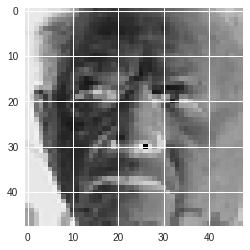

In [40]:
# Sample image
plt.imshow(X_train[0])

### Normalization 

In [0]:
X_train = X_train/255
X_test = X_test/255
X_valid = X_valid/255

### One Hot Encoding

In [0]:
Y_train = data_train['emotion']
Y_test = public_test['emotion']
Y_validation = private_test['emotion']

In [43]:
print(Y_train.shape, Y_test.shape, Y_validation.shape)

(28709,) (3589,) (3589,)


In [0]:
def onehot(Y, C):
  Y = np.eye(C)[Y].T
  return Y

In [45]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [0]:
Y_test = onehot(Y_test, 7).T
Y_train = onehot(Y_train, 7).T
Y_valid = onehot(Y_validation, 7).T

In [47]:
Y_train.shape

(28709, 7)

In [0]:
Y_train = np.array(list(Y_train) + list(Y_train))

In [49]:
Y_train.shape

(57418, 7)

In [0]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=2)

In [0]:
# Clear memory
del data
del data_train
del public_test
del private_test
del Y_validation
del X_train_1
del X_train_flip
del train
del validation
del test

## CNN Models
Taking 3 - 4 models for ensemble voting

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.regularizers import l2

Using TensorFlow backend.


### 1-Basic 5 layer model

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
input_shape = (48, 48, 3)

In [0]:
def Model1(input_shape=(48,48,3)):
  model = Sequential()
  model.add(Conv2D(1, kernel_size=(1, 1), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [55]:
model1 = Model1()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 128)       73856     
__________

In [0]:
model1.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model1.load_weights("drive/face_expr_model1.h5")

In [42]:
model1.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, checkpointer])

Train on 57418 samples, validate on 3589 samples
Epoch 1/5
44480/57418 [======================>.......] - ETA: 27s - loss: 0.4322 - acc: 0.8484

57418/57418 [==============================] - 122s 2ms/step - loss: 0.4353 - acc: 0.8473 - val_loss: 1.1033 - val_acc: 0.6804

Epoch 00001: val_loss improved from inf to 1.10326, saving model to /drive
Epoch 2/5
17728/57418 [========>.....................] - ETA: 1:20 - loss: 0.4295 - acc: 0.8489

57418/57418 [==============================] - 119s 2ms/step - loss: 0.4293 - acc: 0.8500 - val_loss: 1.1096 - val_acc: 0.6748

Epoch 00002: val_loss did not improve from 1.10326
Epoch 3/5
11072/57418 [====>.........................] - ETA: 1:34 - loss: 0.4086 - acc: 0.8595

57418/57418 [==============================] - 119s 2ms/step - loss: 0.4198 - acc: 0.8533 - val_loss: 1.1209 - val_acc: 0.6799

Epoch 00003: val_loss did not improve from 1.10326
Epoch 4/5
 9024/57418 [===>..........................] - ETA: 1:38 - loss: 0.4231 - acc: 0.8522

57418/57418 [==============================] - 119s 2ms/step - loss: 0.4237 - acc: 0.8527 - val_loss: 1.1449 - val_acc: 0.6704

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0004500000213738531.

Epoch 00004: val_loss did not improve from 1.10326
Epoch 5/5
 6400/57418 [==>...........................] - ETA: 1:43 - loss: 0.4059 - acc: 0.8594

57418/57418 [==============================] - 119s 2ms/step - loss: 0.4087 - acc: 0.8575 - val_loss: 1.1278 - val_acc: 0.6760

Epoch 00005: val_loss did not improve from 1.10326


In [0]:
model1.save_weights("drive/face_expr_model1.h5")

In [44]:
model1.evaluate(X_test, Y_test, batch_size=batch_size)

3589/3589 [==============================] - 3s 713us/step


[1.1886951760034703, 0.667038172209419]

In [0]:
model1_2 = Model1()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(horizontal_flip=True,
                        vertical_flip=True)
train_generator_1 = gen.flow(X_train, Y_train, batch_size=batch_size)
 
model1_2.compile(loss=categorical_crossentropy
, optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
, metrics=['accuracy']
)
 

In [0]:
model1_2.load_weights("drive/face_expr_model1_2.h5")

In [49]:
model1_2.fit_generator(train_generator_1, steps_per_epoch=50, epochs=1000)

Epoch 1/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.2164 - acc: 0.5447
Epoch 2/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.2337 - acc: 0.5406
Epoch 3/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2276 - acc: 0.5369
Epoch 4/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2102 - acc: 0.5422
Epoch 5/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2173 - acc: 0.5466
Epoch 6/1000
47/50 [===========================>..] - ETA: 0s - loss: 1.2128 - acc: 0.5422

50/50 [==============================] - 7s 132ms/step - loss: 1.2160 - acc: 0.5425
Epoch 7/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2334 - acc: 0.5359
Epoch 8/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1991 - acc: 0.5603
Epoch 9/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2359 - acc: 0.5363
Epoch 10/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1842 - acc: 0.5403
Epoch 11/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2196 - acc: 0.5459
Epoch 12/1000
 8/50 [===>..........................] - ETA: 5s - loss: 1.2028 - acc: 0.5137

50/50 [==============================] - 7s 132ms/step - loss: 1.2018 - acc: 0.5319
Epoch 13/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2138 - acc: 0.5491
Epoch 14/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1901 - acc: 0.5534
Epoch 15/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1904 - acc: 0.5441
Epoch 16/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2434 - acc: 0.5338
Epoch 17/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.2143 - acc: 0.5363
Epoch 18/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1376 - acc: 0.5703

50/50 [==============================] - 7s 132ms/step - loss: 1.1911 - acc: 0.5494
Epoch 19/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1735 - acc: 0.5572
Epoch 20/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.2137 - acc: 0.5450
Epoch 21/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1781 - acc: 0.5525
Epoch 22/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1658 - acc: 0.5537
Epoch 23/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2156 - acc: 0.5356
Epoch 24/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1860 - acc: 0.5391

50/50 [==============================] - 7s 132ms/step - loss: 1.1806 - acc: 0.5447
Epoch 25/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2284 - acc: 0.5400
Epoch 26/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2077 - acc: 0.5325
Epoch 27/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2054 - acc: 0.5544
Epoch 28/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1750 - acc: 0.5497
Epoch 29/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2225 - acc: 0.5375
Epoch 30/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.2026 - acc: 0.5000

50/50 [==============================] - 7s 131ms/step - loss: 1.2165 - acc: 0.5474
Epoch 31/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1794 - acc: 0.5475
Epoch 32/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1508 - acc: 0.5656
Epoch 33/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1925 - acc: 0.5600
Epoch 34/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1987 - acc: 0.5641
Epoch 35/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2149 - acc: 0.5463
Epoch 36/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1306 - acc: 0.5547

50/50 [==============================] - 7s 131ms/step - loss: 1.1950 - acc: 0.5487
Epoch 37/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1875 - acc: 0.5641
Epoch 38/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1886 - acc: 0.5563
Epoch 39/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1731 - acc: 0.5791
Epoch 40/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1756 - acc: 0.5606
Epoch 41/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1813 - acc: 0.5634
Epoch 42/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1219 - acc: 0.5391

50/50 [==============================] - 7s 132ms/step - loss: 1.1540 - acc: 0.5600
Epoch 43/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2144 - acc: 0.5419
Epoch 44/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1762 - acc: 0.5628
Epoch 45/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2018 - acc: 0.5506
Epoch 46/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1676 - acc: 0.5575
Epoch 47/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1766 - acc: 0.5625
Epoch 48/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1948 - acc: 0.5547

50/50 [==============================] - 7s 131ms/step - loss: 1.1666 - acc: 0.5594
Epoch 49/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1790 - acc: 0.5591
Epoch 50/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2056 - acc: 0.5545
Epoch 51/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1641 - acc: 0.5631
Epoch 52/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1773 - acc: 0.5613
Epoch 53/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1740 - acc: 0.5569
Epoch 54/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1255 - acc: 0.5547

50/50 [==============================] - 7s 132ms/step - loss: 1.1753 - acc: 0.5666
Epoch 55/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1525 - acc: 0.5719
Epoch 56/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.2039 - acc: 0.5563
Epoch 57/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1720 - acc: 0.5625
Epoch 58/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1722 - acc: 0.5641
Epoch 59/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1868 - acc: 0.5444
Epoch 60/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.2116 - acc: 0.6016

50/50 [==============================] - 7s 133ms/step - loss: 1.1501 - acc: 0.5716
Epoch 61/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1534 - acc: 0.5609
Epoch 62/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1502 - acc: 0.5691
Epoch 63/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1979 - acc: 0.5534
Epoch 64/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1285 - acc: 0.5713
Epoch 65/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1930 - acc: 0.5650
Epoch 66/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1884 - acc: 0.5312

50/50 [==============================] - 7s 132ms/step - loss: 1.1671 - acc: 0.5578
Epoch 67/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1764 - acc: 0.5616
Epoch 68/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1688 - acc: 0.5650
Epoch 69/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1621 - acc: 0.5719
Epoch 70/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1531 - acc: 0.5719
Epoch 71/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1613 - acc: 0.5661
Epoch 72/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.3417 - acc: 0.4375

50/50 [==============================] - 7s 131ms/step - loss: 1.2023 - acc: 0.5475
Epoch 73/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1656 - acc: 0.5553
Epoch 74/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1779 - acc: 0.5725
Epoch 75/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1254 - acc: 0.5772
Epoch 76/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1427 - acc: 0.5694
Epoch 77/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1727 - acc: 0.5509
Epoch 78/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1037 - acc: 0.6016

50/50 [==============================] - 7s 133ms/step - loss: 1.1332 - acc: 0.5912
Epoch 79/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1745 - acc: 0.5621
Epoch 80/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1642 - acc: 0.5628
Epoch 81/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1272 - acc: 0.5756
Epoch 82/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1737 - acc: 0.5616
Epoch 83/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1690 - acc: 0.5616
Epoch 84/1000
 1/50 [..............................] - ETA: 6s - loss: 1.1595 - acc: 0.5781

50/50 [==============================] - 7s 133ms/step - loss: 1.1622 - acc: 0.5628
Epoch 85/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1454 - acc: 0.5831
Epoch 86/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1259 - acc: 0.5791
Epoch 87/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1123 - acc: 0.5922
Epoch 88/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1738 - acc: 0.5572
Epoch 89/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1741 - acc: 0.5613
Epoch 90/1000
 1/50 [..............................] - ETA: 6s - loss: 1.1497 - acc: 0.6094

50/50 [==============================] - 7s 131ms/step - loss: 1.1290 - acc: 0.5753
Epoch 91/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1937 - acc: 0.5559
Epoch 92/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1286 - acc: 0.5841
Epoch 93/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1736 - acc: 0.5578
Epoch 94/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1658 - acc: 0.5597
Epoch 95/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1539 - acc: 0.5625
Epoch 96/1000
 1/50 [..............................] - ETA: 6s - loss: 1.1262 - acc: 0.5625

50/50 [==============================] - 7s 133ms/step - loss: 1.1442 - acc: 0.5813
Epoch 97/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1391 - acc: 0.5672
Epoch 98/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1595 - acc: 0.5678
Epoch 99/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1396 - acc: 0.5772
Epoch 100/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1414 - acc: 0.5766
Epoch 101/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1339 - acc: 0.5684
Epoch 102/1000
 1/50 [..............................] - ETA: 6s - loss: 1.2778 - acc: 0.5000

50/50 [==============================] - 7s 133ms/step - loss: 1.1222 - acc: 0.5747
Epoch 103/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1022 - acc: 0.5819
Epoch 104/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1154 - acc: 0.5768
Epoch 105/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1093 - acc: 0.5853
Epoch 106/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1303 - acc: 0.5878
Epoch 107/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1415 - acc: 0.5706
Epoch 108/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.1446 - acc: 0.5744
Epoch 109/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1229 - acc: 0.5875
Epoch 110/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1230 - acc: 0.5866
Epoch 111/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1319 - acc: 0.5750
Epoch 112/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1052 - acc: 0.5981
Epoch 113/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1192 - acc: 0.5781
Epoch 114/1000


50/50 [==============================] - 7s 133ms/step - loss: 1.1200 - acc: 0.5875
Epoch 115/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1329 - acc: 0.5800
Epoch 116/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1224 - acc: 0.5703
Epoch 117/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1309 - acc: 0.5759
Epoch 118/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1303 - acc: 0.5822
Epoch 119/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1417 - acc: 0.5763
Epoch 120/1000


50/50 [==============================] - 7s 133ms/step - loss: 1.1150 - acc: 0.5828
Epoch 121/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1413 - acc: 0.5747
Epoch 122/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1178 - acc: 0.5847
Epoch 123/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1812 - acc: 0.5581
Epoch 124/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1118 - acc: 0.5900
Epoch 125/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1144 - acc: 0.5850
Epoch 126/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.1023 - acc: 0.5872
Epoch 127/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1155 - acc: 0.5813
Epoch 128/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0897 - acc: 0.5891
Epoch 129/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1483 - acc: 0.5660
Epoch 130/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1204 - acc: 0.5819
Epoch 131/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0775 - acc: 0.5975
Epoch 132/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.1410 - acc: 0.5597
Epoch 133/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0894 - acc: 0.5991
Epoch 134/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1250 - acc: 0.5822
Epoch 135/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0849 - acc: 0.5947
Epoch 136/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0933 - acc: 0.5919
Epoch 137/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1328 - acc: 0.5722
Epoch 138/1000


50/50 [==============================] - 7s 133ms/step - loss: 1.1017 - acc: 0.5966
Epoch 139/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1265 - acc: 0.5853
Epoch 140/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1357 - acc: 0.5691
Epoch 141/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1441 - acc: 0.5747
Epoch 142/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1171 - acc: 0.5925
Epoch 143/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1072 - acc: 0.5841
Epoch 144/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.1255 - acc: 0.5716
Epoch 145/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1113 - acc: 0.5836
Epoch 146/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1001 - acc: 0.5841
Epoch 147/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1018 - acc: 0.5844
Epoch 148/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0863 - acc: 0.6044
Epoch 149/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0921 - acc: 0.5894
Epoch 150/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.1068 - acc: 0.5787
Epoch 151/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0899 - acc: 0.5928
Epoch 152/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1303 - acc: 0.5778
Epoch 153/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0979 - acc: 0.5947
Epoch 154/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0935 - acc: 0.5991
Epoch 155/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1032 - acc: 0.5875
Epoch 156/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0984 - acc: 0.5894
Epoch 157/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1062 - acc: 0.5850
Epoch 158/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1021 - acc: 0.5831
Epoch 159/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1111 - acc: 0.5819
Epoch 160/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1021 - acc: 0.5819
Epoch 161/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1082 - acc: 0.5944
Epoch 162/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.1252 - acc: 0.5803
Epoch 163/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0968 - acc: 0.5925
Epoch 164/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1032 - acc: 0.5894
Epoch 165/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0894 - acc: 0.5837
Epoch 166/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0778 - acc: 0.5978
Epoch 167/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0927 - acc: 0.5963
Epoch 168/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.1193 - acc: 0.5747
Epoch 169/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1022 - acc: 0.5850
Epoch 170/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0738 - acc: 0.6081
Epoch 171/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1093 - acc: 0.5881
Epoch 172/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1014 - acc: 0.5884
Epoch 173/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0793 - acc: 0.6053
Epoch 174/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.1086 - acc: 0.5869
Epoch 175/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1051 - acc: 0.5893
Epoch 176/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0954 - acc: 0.5972
Epoch 177/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0809 - acc: 0.5981
Epoch 178/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0913 - acc: 0.5928
Epoch 179/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0833 - acc: 0.5931
Epoch 180/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0493 - acc: 0.6028
Epoch 181/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0790 - acc: 0.6103
Epoch 182/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0552 - acc: 0.5997
Epoch 183/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0970 - acc: 0.5816
Epoch 184/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0644 - acc: 0.6047
Epoch 185/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1064 - acc: 0.5841
Epoch 186/1000


50/50 [==============================] - 7s 133ms/step - loss: 1.0690 - acc: 0.6012
Epoch 187/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1109 - acc: 0.5875
Epoch 188/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0809 - acc: 0.5984
Epoch 189/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0796 - acc: 0.6000
Epoch 190/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0436 - acc: 0.6094
Epoch 191/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.1113 - acc: 0.5912
Epoch 192/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0800 - acc: 0.5934
Epoch 193/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0782 - acc: 0.5972
Epoch 194/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0514 - acc: 0.6034
Epoch 195/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1036 - acc: 0.5822
Epoch 196/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0811 - acc: 0.6072
Epoch 197/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0719 - acc: 0.6050
Epoch 198/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.1131 - acc: 0.5805
Epoch 199/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0476 - acc: 0.6103
Epoch 200/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0320 - acc: 0.6081
Epoch 201/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0800 - acc: 0.5950
Epoch 202/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0714 - acc: 0.6028
Epoch 203/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0988 - acc: 0.5912
Epoch 204/1000


50/50 [==============================] - 7s 133ms/step - loss: 1.0535 - acc: 0.5934
Epoch 205/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0516 - acc: 0.6016
Epoch 206/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0905 - acc: 0.5837
Epoch 207/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0862 - acc: 0.5903
Epoch 208/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0670 - acc: 0.5944
Epoch 209/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0331 - acc: 0.6250
Epoch 210/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0616 - acc: 0.6097
Epoch 211/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.1025 - acc: 0.5813
Epoch 212/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0742 - acc: 0.6025
Epoch 213/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0848 - acc: 0.5972
Epoch 214/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0657 - acc: 0.6034
Epoch 215/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0592 - acc: 0.6034
Epoch 216/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0611 - acc: 0.5934
Epoch 217/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0313 - acc: 0.6194
Epoch 218/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0838 - acc: 0.5884
Epoch 219/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0345 - acc: 0.6019
Epoch 220/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0705 - acc: 0.6096
Epoch 221/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0518 - acc: 0.6128
Epoch 222/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0429 - acc: 0.6012
Epoch 223/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0397 - acc: 0.6169
Epoch 224/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0451 - acc: 0.6025
Epoch 225/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0921 - acc: 0.5978
Epoch 226/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0492 - acc: 0.6006
Epoch 227/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0341 - acc: 0.6200
Epoch 228/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0397 - acc: 0.6153
Epoch 229/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0730 - acc: 0.5950
Epoch 230/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0619 - acc: 0.6025
Epoch 231/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0700 - acc: 0.6025
Epoch 232/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0735 - acc: 0.6044
Epoch 233/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0409 - acc: 0.6159
Epoch 234/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0540 - acc: 0.6094
Epoch 235/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0662 - acc: 0.6038
Epoch 236/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0160 - acc: 0.6250
Epoch 237/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0571 - acc: 0.6125
Epoch 238/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0358 - acc: 0.6100
Epoch 239/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0468 - acc: 0.6125
Epoch 240/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0530 - acc: 0.6100
Epoch 241/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0800 - acc: 0.5928
Epoch 242/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0726 - acc: 0.5938
Epoch 243/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0510 - acc: 0.6119
Epoch 244/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0128 - acc: 0.6188
Epoch 245/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0613 - acc: 0.6041
Epoch 246/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0236 - acc: 0.6209
Epoch 247/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0310 - acc: 0.6206
Epoch 248/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0524 - acc: 0.6141
Epoch 249/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0132 - acc: 0.6153
Epoch 250/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0575 - acc: 0.5997
Epoch 251/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0429 - acc: 0.6097
Epoch 252/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0392 - acc: 0.5966
Epoch 253/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9948 - acc: 0.6381
Epoch 254/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0481 - acc: 0.6122
Epoch 255/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0593 - acc: 0.6106
Epoch 256/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0487 - acc: 0.6053
Epoch 257/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0176 - acc: 0.6116
Epoch 258/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0311 - acc: 0.6100
Epoch 259/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0500 - acc: 0.6041
Epoch 260/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0309 - acc: 0.6209
Epoch 261/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0728 - acc: 0.5956
Epoch 262/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0691 - acc: 0.5981
Epoch 263/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0249 - acc: 0.6184
Epoch 264/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0397 - acc: 0.6094
Epoch 265/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0379 - acc: 0.6112
Epoch 266/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0281 - acc: 0.6125
Epoch 267/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0100 - acc: 0.6178
Epoch 268/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0470 - acc: 0.6044
Epoch 269/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0296 - acc: 0.6178
Epoch 270/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0170 - acc: 0.6116
Epoch 271/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0089 - acc: 0.6262
Epoch 272/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0262 - acc: 0.6178
Epoch 273/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0573 - acc: 0.6103
Epoch 274/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9990 - acc: 0.6278
Epoch 275/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0182 - acc: 0.6244
Epoch 276/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0313 - acc: 0.6081
Epoch 277/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0344 - acc: 0.6134
Epoch 278/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0167 - acc: 0.6309
Epoch 279/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0039 - acc: 0.6284
Epoch 280/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0383 - acc: 0.6144
Epoch 281/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0425 - acc: 0.6197
Epoch 282/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0261 - acc: 0.6119
Epoch 283/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0518 - acc: 0.6072
Epoch 284/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0463 - acc: 0.6094
Epoch 285/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0195 - acc: 0.6066
Epoch 286/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0252 - acc: 0.6234
Epoch 287/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0234 - acc: 0.6303
Epoch 288/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0217 - acc: 0.6291
Epoch 289/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0146 - acc: 0.6175
Epoch 290/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0211 - acc: 0.6272
Epoch 291/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0311 - acc: 0.6238
Epoch 292/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0237 - acc: 0.6225
Epoch 293/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0014 - acc: 0.6225
Epoch 294/1000


50/50 [==============================] - 7s 133ms/step - loss: 1.0278 - acc: 0.6191
Epoch 295/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0223 - acc: 0.6184
Epoch 296/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0340 - acc: 0.6109
Epoch 297/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0008 - acc: 0.6297
Epoch 298/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0208 - acc: 0.6212
Epoch 299/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0164 - acc: 0.6228
Epoch 300/1000


50/50 [==============================] - 7s 133ms/step - loss: 1.0222 - acc: 0.6147
Epoch 301/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0407 - acc: 0.6215
Epoch 302/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0341 - acc: 0.6188
Epoch 303/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0222 - acc: 0.6256
Epoch 304/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0042 - acc: 0.6362
Epoch 305/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0055 - acc: 0.6247
Epoch 306/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9806 - acc: 0.6369
Epoch 307/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0071 - acc: 0.6222
Epoch 308/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0063 - acc: 0.6266
Epoch 309/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0126 - acc: 0.6227
Epoch 310/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0419 - acc: 0.6062
Epoch 311/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9995 - acc: 0.6272
Epoch 312/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0177 - acc: 0.6284
Epoch 313/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0121 - acc: 0.6200
Epoch 314/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0001 - acc: 0.6269
Epoch 315/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9957 - acc: 0.6344
Epoch 316/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9962 - acc: 0.6347
Epoch 317/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9849 - acc: 0.6300
Epoch 318/1000


50/50 [==============================] - 7s 132ms/step - loss: 1.0468 - acc: 0.6150
Epoch 319/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0208 - acc: 0.6128
Epoch 320/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9889 - acc: 0.6328
Epoch 321/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9892 - acc: 0.6338
Epoch 322/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0145 - acc: 0.6203
Epoch 323/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0436 - acc: 0.6172
Epoch 324/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9965 - acc: 0.6391
Epoch 325/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0175 - acc: 0.6219
Epoch 326/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9830 - acc: 0.6462
Epoch 327/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0034 - acc: 0.6312
Epoch 328/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0011 - acc: 0.6242
Epoch 329/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9762 - acc: 0.6303
Epoch 330/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.9881 - acc: 0.6353
Epoch 331/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0027 - acc: 0.6272
Epoch 332/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0029 - acc: 0.6206
Epoch 333/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9892 - acc: 0.6291
Epoch 334/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0114 - acc: 0.6234
Epoch 335/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9806 - acc: 0.6287
Epoch 336/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9990 - acc: 0.6378
Epoch 337/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0070 - acc: 0.6319
Epoch 338/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0031 - acc: 0.6316
Epoch 339/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9665 - acc: 0.6441
Epoch 340/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0270 - acc: 0.6147
Epoch 341/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0084 - acc: 0.6212
Epoch 342/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9889 - acc: 0.6328
Epoch 343/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9527 - acc: 0.6541
Epoch 344/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9869 - acc: 0.6278
Epoch 345/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9811 - acc: 0.6276
Epoch 346/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0138 - acc: 0.6306
Epoch 347/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9925 - acc: 0.6278
Epoch 348/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9826 - acc: 0.6409
Epoch 349/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0052 - acc: 0.6256
Epoch 350/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0250 - acc: 0.6112
Epoch 351/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9908 - acc: 0.6359
Epoch 352/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9856 - acc: 0.6394
Epoch 353/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0059 - acc: 0.6319
Epoch 354/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9877 - acc: 0.6294
Epoch 355/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.0082 - acc: 0.6209
Epoch 356/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9754 - acc: 0.6231
Epoch 357/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9811 - acc: 0.6319
Epoch 358/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9747 - acc: 0.6344
Epoch 359/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9910 - acc: 0.6222
Epoch 360/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9798 - acc: 0.6378
Epoch 361/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9940 - acc: 0.6272
Epoch 362/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9817 - acc: 0.6197
Epoch 363/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9716 - acc: 0.6394
Epoch 364/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9930 - acc: 0.6271
Epoch 365/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9514 - acc: 0.6478
Epoch 366/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0033 - acc: 0.6284
Epoch 367/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9558 - acc: 0.6456
Epoch 368/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9573 - acc: 0.6497
Epoch 369/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9874 - acc: 0.6369
Epoch 370/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9794 - acc: 0.6275
Epoch 371/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9668 - acc: 0.6472
Epoch 372/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9889 - acc: 0.6334
Epoch 373/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9893 - acc: 0.6316
Epoch 374/1000
50/50 [==============================] - 7s 133ms/step - loss: 1.0058 - acc: 0.6294
Epoch 375/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9929 - acc: 0.6209
Epoch 376/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9994 - acc: 0.6231
Epoch 377/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9831 - acc: 0.6434
Epoch 378/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9985 - acc: 0.6300
Epoch 379/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9721 - acc: 0.6297
Epoch 380/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9896 - acc: 0.6403
Epoch 381/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9951 - acc: 0.6388
Epoch 382/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9652 - acc: 0.6422
Epoch 383/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9670 - acc: 0.6353
Epoch 384/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9618 - acc: 0.6534
Epoch 385/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9706 - acc: 0.6419
Epoch 386/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9869 - acc: 0.6400
Epoch 387/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9765 - acc: 0.6370
Epoch 388/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9816 - acc: 0.6372
Epoch 389/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9615 - acc: 0.6425
Epoch 390/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9870 - acc: 0.6338
Epoch 391/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9542 - acc: 0.6472
Epoch 392/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9676 - acc: 0.6341
Epoch 393/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9939 - acc: 0.6181
Epoch 394/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9575 - acc: 0.6416
Epoch 395/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9845 - acc: 0.6353
Epoch 396/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9588 - acc: 0.6469
Epoch 397/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9877 - acc: 0.6241
Epoch 398/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9353 - acc: 0.6497
Epoch 399/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9525 - acc: 0.6594
Epoch 400/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9784 - acc: 0.6347
Epoch 401/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9790 - acc: 0.6369
Epoch 402/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9686 - acc: 0.6444
Epoch 403/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9628 - acc: 0.6391
Epoch 404/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9695 - acc: 0.6350
Epoch 405/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9472 - acc: 0.6466
Epoch 406/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9866 - acc: 0.6359
Epoch 407/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9686 - acc: 0.6437
Epoch 408/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9878 - acc: 0.6403
Epoch 409/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9498 - acc: 0.6462
Epoch 410/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9619 - acc: 0.6531
Epoch 411/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9419 - acc: 0.6572
Epoch 412/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9583 - acc: 0.6422
Epoch 413/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9420 - acc: 0.6521
Epoch 414/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9813 - acc: 0.6334
Epoch 415/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9595 - acc: 0.6562
Epoch 416/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9547 - acc: 0.6416
Epoch 417/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9681 - acc: 0.6434
Epoch 418/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9528 - acc: 0.6450
Epoch 419/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9383 - acc: 0.6562
Epoch 420/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9976 - acc: 0.6238
Epoch 421/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9347 - acc: 0.6497
Epoch 422/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9884 - acc: 0.6262
Epoch 423/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9475 - acc: 0.6469
Epoch 424/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9660 - acc: 0.6459
Epoch 425/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9733 - acc: 0.6428
Epoch 426/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9416 - acc: 0.6494
Epoch 427/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9236 - acc: 0.6488
Epoch 428/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9225 - acc: 0.6556
Epoch 429/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9309 - acc: 0.6562
Epoch 430/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9410 - acc: 0.6437
Epoch 431/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9466 - acc: 0.6450
Epoch 432/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9396 - acc: 0.6594
Epoch 433/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9646 - acc: 0.6397
Epoch 434/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9623 - acc: 0.6422
Epoch 435/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9864 - acc: 0.6353
Epoch 436/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9431 - acc: 0.6450
Epoch 437/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9287 - acc: 0.6503
Epoch 438/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9313 - acc: 0.6587
Epoch 439/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9367 - acc: 0.6613
Epoch 440/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9782 - acc: 0.6481
Epoch 441/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9404 - acc: 0.6478
Epoch 442/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9777 - acc: 0.6372
Epoch 443/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9222 - acc: 0.6541
Epoch 444/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9334 - acc: 0.6356
Epoch 445/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9399 - acc: 0.6574
Epoch 446/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9478 - acc: 0.6416
Epoch 447/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9256 - acc: 0.6472
Epoch 448/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9828 - acc: 0.6447
Epoch 449/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9209 - acc: 0.6544
Epoch 450/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9490 - acc: 0.6494
Epoch 451/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8938 - acc: 0.6744
Epoch 452/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9445 - acc: 0.6444
Epoch 453/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9496 - acc: 0.6594
Epoch 454/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9381 - acc: 0.6419
Epoch 455/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9116 - acc: 0.6731
Epoch 456/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9794 - acc: 0.6456
Epoch 457/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9114 - acc: 0.6641
Epoch 458/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9646 - acc: 0.6434
Epoch 459/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9277 - acc: 0.6509
Epoch 460/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9284 - acc: 0.6584
Epoch 461/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9483 - acc: 0.6412
Epoch 462/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.9414 - acc: 0.6416
Epoch 463/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9467 - acc: 0.6500
Epoch 464/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9448 - acc: 0.6428
Epoch 465/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9540 - acc: 0.6397
Epoch 466/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9461 - acc: 0.6475
Epoch 467/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9219 - acc: 0.6525
Epoch 468/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9045 - acc: 0.6619
Epoch 469/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9256 - acc: 0.6506
Epoch 470/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9325 - acc: 0.6522
Epoch 471/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9349 - acc: 0.6478
Epoch 472/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9407 - acc: 0.6531
Epoch 473/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9145 - acc: 0.6647
Epoch 474/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9301 - acc: 0.6569
Epoch 475/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9055 - acc: 0.6578
Epoch 476/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9251 - acc: 0.6538
Epoch 477/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9003 - acc: 0.6603
Epoch 478/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9347 - acc: 0.6516
Epoch 479/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8978 - acc: 0.6628
Epoch 480/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9403 - acc: 0.6475
Epoch 481/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9216 - acc: 0.6509
Epoch 482/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9523 - acc: 0.6550
Epoch 483/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9301 - acc: 0.6500
Epoch 484/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9508 - acc: 0.6381
Epoch 485/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9630 - acc: 0.6569
Epoch 486/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.9244 - acc: 0.6503
Epoch 487/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9166 - acc: 0.6562
Epoch 488/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8924 - acc: 0.6631
Epoch 489/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9365 - acc: 0.6538
Epoch 490/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9021 - acc: 0.6553
Epoch 491/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9627 - acc: 0.6419
Epoch 492/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9295 - acc: 0.6534
Epoch 493/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9288 - acc: 0.6494
Epoch 494/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9295 - acc: 0.6506
Epoch 495/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9167 - acc: 0.6597
Epoch 496/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9136 - acc: 0.6591
Epoch 497/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9136 - acc: 0.6600
Epoch 498/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9259 - acc: 0.6587
Epoch 499/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8913 - acc: 0.6606
Epoch 500/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9355 - acc: 0.6581
Epoch 501/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9349 - acc: 0.6633
Epoch 502/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9414 - acc: 0.6497
Epoch 503/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9233 - acc: 0.6572
Epoch 504/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8778 - acc: 0.6750
Epoch 505/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9306 - acc: 0.6572
Epoch 506/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8956 - acc: 0.6706
Epoch 507/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9010 - acc: 0.6634
Epoch 508/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8961 - acc: 0.6781
Epoch 509/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9125 - acc: 0.6616
Epoch 510/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9454 - acc: 0.6572
Epoch 511/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9164 - acc: 0.6456
Epoch 512/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9425 - acc: 0.6534
Epoch 513/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9116 - acc: 0.6506
Epoch 514/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8985 - acc: 0.6613
Epoch 515/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9140 - acc: 0.6578
Epoch 516/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.9097 - acc: 0.6694
Epoch 517/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9473 - acc: 0.6422
Epoch 518/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9136 - acc: 0.6587
Epoch 519/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8972 - acc: 0.6591
Epoch 520/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9448 - acc: 0.6488
Epoch 521/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9022 - acc: 0.6587
Epoch 522/1000
 1/50 [..............................] - ETA: 6s - loss: 0.8120 - acc: 0.7188

50/50 [==============================] - 7s 132ms/step - loss: 0.9087 - acc: 0.6509
Epoch 523/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9039 - acc: 0.6516
Epoch 524/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9265 - acc: 0.6550
Epoch 525/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8970 - acc: 0.6644
Epoch 526/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8859 - acc: 0.6719
Epoch 527/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8935 - acc: 0.6675
Epoch 528/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8814 - acc: 0.6688
Epoch 529/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9075 - acc: 0.6587
Epoch 530/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9107 - acc: 0.6594
Epoch 531/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8826 - acc: 0.6681
Epoch 532/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8878 - acc: 0.6728
Epoch 533/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8818 - acc: 0.6772
Epoch 534/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9000 - acc: 0.6634
Epoch 535/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8840 - acc: 0.6775
Epoch 536/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9027 - acc: 0.6750
Epoch 537/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9182 - acc: 0.6597
Epoch 538/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9063 - acc: 0.6719
Epoch 539/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8935 - acc: 0.6644
Epoch 540/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8733 - acc: 0.6794
Epoch 541/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8667 - acc: 0.6800
Epoch 542/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8920 - acc: 0.6650
Epoch 543/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8897 - acc: 0.6681
Epoch 544/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9147 - acc: 0.6575
Epoch 545/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8965 - acc: 0.6719
Epoch 546/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8970 - acc: 0.6688
Epoch 547/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8964 - acc: 0.6684
Epoch 548/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8834 - acc: 0.6726
Epoch 549/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9156 - acc: 0.6584
Epoch 550/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8940 - acc: 0.6594
Epoch 551/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9084 - acc: 0.6744
Epoch 552/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8825 - acc: 0.6591
Epoch 553/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9146 - acc: 0.6703
Epoch 554/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9257 - acc: 0.6647
Epoch 555/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9071 - acc: 0.6637
Epoch 556/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9112 - acc: 0.6625
Epoch 557/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9067 - acc: 0.6663
Epoch 558/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8740 - acc: 0.6797
Epoch 559/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9233 - acc: 0.6523
Epoch 560/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8749 - acc: 0.6666
Epoch 561/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8916 - acc: 0.6672
Epoch 562/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9411 - acc: 0.6472
Epoch 563/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8773 - acc: 0.6834
Epoch 564/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.9006 - acc: 0.6569
Epoch 565/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8948 - acc: 0.6659
Epoch 566/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8722 - acc: 0.6756
Epoch 567/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8856 - acc: 0.6741
Epoch 568/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8965 - acc: 0.6606
Epoch 569/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8953 - acc: 0.6781
Epoch 570/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.8932 - acc: 0.6725
Epoch 571/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8694 - acc: 0.6747
Epoch 572/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8869 - acc: 0.6684
Epoch 573/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8459 - acc: 0.6894
Epoch 574/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8827 - acc: 0.6803
Epoch 575/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9171 - acc: 0.6631
Epoch 576/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8679 - acc: 0.6737
Epoch 577/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9091 - acc: 0.6688
Epoch 578/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8612 - acc: 0.6850
Epoch 579/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8848 - acc: 0.6809
Epoch 580/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9030 - acc: 0.6613
Epoch 581/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8781 - acc: 0.6705


Epoch 582/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8989 - acc: 0.6688
Epoch 583/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8697 - acc: 0.6750
Epoch 584/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8957 - acc: 0.6606
Epoch 585/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8584 - acc: 0.6794
Epoch 586/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8577 - acc: 0.6775
Epoch 587/1000
44/50 [=========================>....] - ETA: 0s - loss: 0.8688 - acc: 0.6815

50/50 [==============================] - 7s 132ms/step - loss: 0.8599 - acc: 0.6816
Epoch 588/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8989 - acc: 0.6725
Epoch 589/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8916 - acc: 0.6694
Epoch 590/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8923 - acc: 0.6569
Epoch 591/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8747 - acc: 0.6822
Epoch 592/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8863 - acc: 0.6672
Epoch 593/1000
 5/50 [==>...........................] - ETA: 5s - loss: 0.8785 - acc: 0.6875

50/50 [==============================] - 7s 132ms/step - loss: 0.8679 - acc: 0.6787
Epoch 594/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8783 - acc: 0.6847
Epoch 595/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8992 - acc: 0.6691
Epoch 596/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8787 - acc: 0.6853
Epoch 597/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8835 - acc: 0.6656
Epoch 598/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8722 - acc: 0.6759
Epoch 599/1000
 1/50 [..............................] - ETA: 6s - loss: 0.8152 - acc: 0.7031

50/50 [==============================] - 7s 132ms/step - loss: 0.8759 - acc: 0.6825
Epoch 600/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9102 - acc: 0.6581
Epoch 601/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8517 - acc: 0.6925
Epoch 602/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8538 - acc: 0.6869
Epoch 603/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8677 - acc: 0.6778
Epoch 604/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8874 - acc: 0.6747
Epoch 605/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8741 - acc: 0.6591
Epoch 606/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8480 - acc: 0.6895
Epoch 607/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8580 - acc: 0.6697
Epoch 608/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8538 - acc: 0.6850
Epoch 609/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.9123 - acc: 0.6653
Epoch 610/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8990 - acc: 0.6728
Epoch 611/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8855 - acc: 0.6569
Epoch 612/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8432 - acc: 0.6831
Epoch 613/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9013 - acc: 0.6713
Epoch 614/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8516 - acc: 0.6869
Epoch 615/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8804 - acc: 0.6756
Epoch 616/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8870 - acc: 0.6743
Epoch 617/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.8817 - acc: 0.6691
Epoch 618/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8779 - acc: 0.6747
Epoch 619/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8698 - acc: 0.6775
Epoch 620/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8463 - acc: 0.6884
Epoch 621/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8540 - acc: 0.6800
Epoch 622/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8571 - acc: 0.6859
Epoch 623/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8840 - acc: 0.6694
Epoch 624/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8806 - acc: 0.6700
Epoch 625/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8532 - acc: 0.6816
Epoch 626/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8416 - acc: 0.6859
Epoch 627/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8598 - acc: 0.6784
Epoch 628/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8564 - acc: 0.6838
Epoch 629/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8872 - acc: 0.6734
Epoch 630/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8642 - acc: 0.6741
Epoch 631/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8546 - acc: 0.6816
Epoch 632/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8324 - acc: 0.6875
Epoch 633/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8919 - acc: 0.6706
Epoch 634/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8614 - acc: 0.6931
Epoch 635/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8596 - acc: 0.6775
Epoch 636/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8659 - acc: 0.6822
Epoch 637/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8355 - acc: 0.6925
Epoch 638/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8558 - acc: 0.6819
Epoch 639/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8395 - acc: 0.6853
Epoch 640/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.9231 - acc: 0.6634
Epoch 641/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8622 - acc: 0.6772
Epoch 642/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8593 - acc: 0.6716
Epoch 643/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8414 - acc: 0.6844
Epoch 644/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8496 - acc: 0.6881
Epoch 645/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8654 - acc: 0.6856
Epoch 646/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8284 - acc: 0.6956
Epoch 647/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8520 - acc: 0.6816
Epoch 648/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8283 - acc: 0.6937
Epoch 649/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8785 - acc: 0.6787
Epoch 650/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8531 - acc: 0.6891
Epoch 651/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8640 - acc: 0.6756
Epoch 652/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8765 - acc: 0.6897
Epoch 653/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8885 - acc: 0.6587
Epoch 654/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8652 - acc: 0.6809
Epoch 655/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8591 - acc: 0.6813
Epoch 656/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8303 - acc: 0.6903
Epoch 657/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8487 - acc: 0.6834
Epoch 658/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8291 - acc: 0.6925
Epoch 659/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.8542 - acc: 0.6928
Epoch 660/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8348 - acc: 0.6884
Epoch 661/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8445 - acc: 0.6906
Epoch 662/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8630 - acc: 0.6806
Epoch 663/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8592 - acc: 0.6774
Epoch 664/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8717 - acc: 0.6769
Epoch 665/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8539 - acc: 0.6925
Epoch 666/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8395 - acc: 0.6863
Epoch 667/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8129 - acc: 0.6969
Epoch 668/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8446 - acc: 0.6831
Epoch 669/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8763 - acc: 0.6678
Epoch 670/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8196 - acc: 0.6931
Epoch 671/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8593 - acc: 0.6772
Epoch 672/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8599 - acc: 0.6847
Epoch 673/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8218 - acc: 0.6956
Epoch 674/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8318 - acc: 0.6903
Epoch 675/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8224 - acc: 0.6912
Epoch 676/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8708 - acc: 0.6778
Epoch 677/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8458 - acc: 0.6878
Epoch 678/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8274 - acc: 0.6872
Epoch 679/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8628 - acc: 0.6806
Epoch 680/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8466 - acc: 0.6972
Epoch 681/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8715 - acc: 0.6806
Epoch 682/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8671 - acc: 0.6762
Epoch 683/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8609 - acc: 0.6825
Epoch 684/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8225 - acc: 0.7041
Epoch 685/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8341 - acc: 0.7034
Epoch 686/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8472 - acc: 0.6806
Epoch 687/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8610 - acc: 0.6813
Epoch 688/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8368 - acc: 0.6978
Epoch 689/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8653 - acc: 0.6819
Epoch 690/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8082 - acc: 0.7066
Epoch 691/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8313 - acc: 0.6937
Epoch 692/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8595 - acc: 0.6775
Epoch 693/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8423 - acc: 0.6806
Epoch 694/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8623 - acc: 0.6775


Epoch 695/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8627 - acc: 0.6797
Epoch 696/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8281 - acc: 0.6881
Epoch 697/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8450 - acc: 0.6856
Epoch 698/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8307 - acc: 0.6984
Epoch 699/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8271 - acc: 0.6847
Epoch 700/1000
44/50 [=========================>....] - ETA: 0s - loss: 0.8368 - acc: 0.6953

50/50 [==============================] - 7s 132ms/step - loss: 0.8368 - acc: 0.6944
Epoch 701/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7901 - acc: 0.7125
Epoch 702/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8159 - acc: 0.7113
Epoch 703/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8199 - acc: 0.7044
Epoch 704/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8549 - acc: 0.6813
Epoch 705/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8296 - acc: 0.6937
Epoch 706/1000
 5/50 [==>...........................] - ETA: 5s - loss: 0.7841 - acc: 0.6813

50/50 [==============================] - 7s 131ms/step - loss: 0.8143 - acc: 0.7003
Epoch 707/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8734 - acc: 0.6834
Epoch 708/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8494 - acc: 0.6864
Epoch 709/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8532 - acc: 0.6822
Epoch 710/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8543 - acc: 0.6872
Epoch 711/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8306 - acc: 0.7025
Epoch 712/1000
 1/50 [..............................] - ETA: 6s - loss: 0.7927 - acc: 0.6719

50/50 [==============================] - 7s 131ms/step - loss: 0.8393 - acc: 0.6922
Epoch 713/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8332 - acc: 0.6869
Epoch 714/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8164 - acc: 0.6931
Epoch 715/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8429 - acc: 0.6831
Epoch 716/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8191 - acc: 0.6981
Epoch 717/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8438 - acc: 0.6919
Epoch 718/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8289 - acc: 0.6966
Epoch 719/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8205 - acc: 0.6978
Epoch 720/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8018 - acc: 0.7094
Epoch 721/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7931 - acc: 0.6997
Epoch 722/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8432 - acc: 0.6916
Epoch 723/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8009 - acc: 0.7188
Epoch 724/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8100 - acc: 0.7025
Epoch 725/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8146 - acc: 0.6928
Epoch 726/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8413 - acc: 0.6944
Epoch 727/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8170 - acc: 0.6928
Epoch 728/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8265 - acc: 0.6944
Epoch 729/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8220 - acc: 0.7059
Epoch 730/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8011 - acc: 0.7062
Epoch 731/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8427 - acc: 0.6787
Epoch 732/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8167 - acc: 0.6911
Epoch 733/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8316 - acc: 0.6922
Epoch 734/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8358 - acc: 0.6963
Epoch 735/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8479 - acc: 0.6919
Epoch 736/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8352 - acc: 0.6928
Epoch 737/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8090 - acc: 0.6972
Epoch 738/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8118 - acc: 0.6931
Epoch 739/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8254 - acc: 0.6872
Epoch 740/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7875 - acc: 0.7125
Epoch 741/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8224 - acc: 0.7091
Epoch 742/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8190 - acc: 0.6875
Epoch 743/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.7899 - acc: 0.7106
Epoch 744/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8275 - acc: 0.6884
Epoch 745/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8769 - acc: 0.6731
Epoch 746/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8022 - acc: 0.7116
Epoch 747/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8297 - acc: 0.6978
Epoch 748/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.8436 - acc: 0.6859
Epoch 749/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7969 - acc: 0.7047
Epoch 750/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7919 - acc: 0.7081
Epoch 751/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8168 - acc: 0.7016
Epoch 752/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8095 - acc: 0.6994
Epoch 753/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8105 - acc: 0.6975
Epoch 754/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8183 - acc: 0.6987
Epoch 755/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7994 - acc: 0.7031
Epoch 756/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7765 - acc: 0.7100
Epoch 757/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8157 - acc: 0.6981
Epoch 758/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8478 - acc: 0.6834
Epoch 759/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8081 - acc: 0.7066
Epoch 760/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7855 - acc: 0.7172
Epoch 761/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8206 - acc: 0.7009
Epoch 762/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8101 - acc: 0.6987
Epoch 763/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8310 - acc: 0.6966
Epoch 764/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8060 - acc: 0.6941
Epoch 765/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8002 - acc: 0.7022
Epoch 766/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8168 - acc: 0.6975
Epoch 767/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8175 - acc: 0.6981
Epoch 768/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8362 - acc: 0.6884
Epoch 769/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8133 - acc: 0.7075
Epoch 770/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8087 - acc: 0.6994
Epoch 771/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7845 - acc: 0.7106
Epoch 772/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8116 - acc: 0.6937
Epoch 773/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8210 - acc: 0.6994
Epoch 774/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7881 - acc: 0.7050
Epoch 775/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8199 - acc: 0.6959
Epoch 776/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7924 - acc: 0.7025
Epoch 777/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7945 - acc: 0.6997
Epoch 778/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8009 - acc: 0.6928
Epoch 779/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7998 - acc: 0.7084
Epoch 780/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7925 - acc: 0.7069
Epoch 781/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.8156 - acc: 0.6944
Epoch 782/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8171 - acc: 0.6928
Epoch 783/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8166 - acc: 0.6928
Epoch 784/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8129 - acc: 0.7144
Epoch 785/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8174 - acc: 0.7047
Epoch 786/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7909 - acc: 0.7097
Epoch 787/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8071 - acc: 0.7041
Epoch 788/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8027 - acc: 0.6953
Epoch 789/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8218 - acc: 0.6929
Epoch 790/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7757 - acc: 0.7153
Epoch 791/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7879 - acc: 0.7125
Epoch 792/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8055 - acc: 0.6978
Epoch 793/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8268 - acc: 0.6844
Epoch 794/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7967 - acc: 0.7069
Epoch 795/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8029 - acc: 0.6997
Epoch 796/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7889 - acc: 0.7109
Epoch 797/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7742 - acc: 0.7200
Epoch 798/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8010 - acc: 0.6975
Epoch 799/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8067 - acc: 0.7016
Epoch 800/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8159 - acc: 0.7009
Epoch 801/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7883 - acc: 0.7061
Epoch 802/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7913 - acc: 0.6987
Epoch 803/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7912 - acc: 0.7078
Epoch 804/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7843 - acc: 0.7075
Epoch 805/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7888 - acc: 0.7141
Epoch 806/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8072 - acc: 0.7075
Epoch 807/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7898 - acc: 0.7053
Epoch 808/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7962 - acc: 0.7069
Epoch 809/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7851 - acc: 0.7078
Epoch 810/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7829 - acc: 0.7178
Epoch 811/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7934 - acc: 0.7072
Epoch 812/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7835 - acc: 0.7003
Epoch 813/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7805 - acc: 0.7206
Epoch 814/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8016 - acc: 0.7119
Epoch 815/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7846 - acc: 0.7134
Epoch 816/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7999 - acc: 0.7075
Epoch 817/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8457 - acc: 0.6859
Epoch 818/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7794 - acc: 0.7156
Epoch 819/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7931 - acc: 0.7122
Epoch 820/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.7785 - acc: 0.7101
Epoch 821/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7721 - acc: 0.7125
Epoch 822/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7792 - acc: 0.7163
Epoch 823/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7738 - acc: 0.7172
Epoch 824/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7811 - acc: 0.7037
Epoch 825/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8132 - acc: 0.6963
Epoch 826/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7902 - acc: 0.7087
Epoch 827/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7696 - acc: 0.7137
Epoch 828/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8154 - acc: 0.7053
Epoch 829/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8075 - acc: 0.7009
Epoch 830/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7728 - acc: 0.7094
Epoch 831/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7827 - acc: 0.7116
Epoch 832/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7897 - acc: 0.7028
Epoch 833/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7818 - acc: 0.7122
Epoch 834/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7799 - acc: 0.7109
Epoch 835/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8154 - acc: 0.7041
Epoch 836/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7788 - acc: 0.7141
Epoch 837/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7814 - acc: 0.7081
Epoch 838/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7700 - acc: 0.7084
Epoch 839/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7575 - acc: 0.7087
Epoch 840/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8246 - acc: 0.7034
Epoch 841/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7765 - acc: 0.7306
Epoch 842/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7939 - acc: 0.7022
Epoch 843/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7887 - acc: 0.7078
Epoch 844/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8066 - acc: 0.7028
Epoch 845/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7873 - acc: 0.7048
Epoch 846/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7890 - acc: 0.7031
Epoch 847/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7668 - acc: 0.7137
Epoch 848/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7796 - acc: 0.7034
Epoch 849/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7510 - acc: 0.7144
Epoch 850/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7704 - acc: 0.7094
Epoch 851/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7479 - acc: 0.7306
Epoch 852/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7782 - acc: 0.7109
Epoch 853/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8013 - acc: 0.7016
Epoch 854/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7733 - acc: 0.7175
Epoch 855/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.8104 - acc: 0.7069
Epoch 856/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.7813 - acc: 0.7141
Epoch 857/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7727 - acc: 0.7125
Epoch 858/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7451 - acc: 0.7212
Epoch 859/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7328 - acc: 0.7356
Epoch 860/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7620 - acc: 0.7262
Epoch 861/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7877 - acc: 0.7169
Epoch 862/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7879 - acc: 0.7087
Epoch 863/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7762 - acc: 0.7200
Epoch 864/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7792 - acc: 0.7131
Epoch 865/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7775 - acc: 0.7178
Epoch 866/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7713 - acc: 0.7212
Epoch 867/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7618 - acc: 0.7150
Epoch 868/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7936 - acc: 0.7119
Epoch 869/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7623 - acc: 0.7250
Epoch 870/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7793 - acc: 0.7094
Epoch 871/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7501 - acc: 0.7219
Epoch 872/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7660 - acc: 0.7231
Epoch 873/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7713 - acc: 0.7166
Epoch 874/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7730 - acc: 0.7172
Epoch 875/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7612 - acc: 0.7169
Epoch 876/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7858 - acc: 0.7163
Epoch 877/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7798 - acc: 0.7150
Epoch 878/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7858 - acc: 0.7106
Epoch 879/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7710 - acc: 0.7122
Epoch 880/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.7887 - acc: 0.7101
Epoch 881/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7563 - acc: 0.7184
Epoch 882/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7752 - acc: 0.7234
Epoch 883/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7449 - acc: 0.7259
Epoch 884/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.7490 - acc: 0.7290
Epoch 885/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7550 - acc: 0.7231
Epoch 886/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.7663 - acc: 0.7300
Epoch 887/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7412 - acc: 0.7203
Epoch 888/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7404 - acc: 0.7272
Epoch 889/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7751 - acc: 0.7197
Epoch 890/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7473 - acc: 0.7272
Epoch 891/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7507 - acc: 0.7328
Epoch 892/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.8030 - acc: 0.7078
Epoch 893/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7792 - acc: 0.7259
Epoch 894/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7653 - acc: 0.7191
Epoch 895/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7725 - acc: 0.7156
Epoch 896/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7762 - acc: 0.7144
Epoch 897/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7741 - acc: 0.7137
Epoch 898/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.7682 - acc: 0.7219
Epoch 899/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7802 - acc: 0.7122
Epoch 900/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7579 - acc: 0.7334
Epoch 901/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.7602 - acc: 0.7219
Epoch 902/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7685 - acc: 0.7216
Epoch 903/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7599 - acc: 0.7209
Epoch 904/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7634 - acc: 0.7216
Epoch 905/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7502 - acc: 0.7253
Epoch 906/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7435 - acc: 0.7275
Epoch 907/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7476 - acc: 0.7256
Epoch 908/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7776 - acc: 0.7203
Epoch 909/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7479 - acc: 0.7238
Epoch 910/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7277 - acc: 0.7338
Epoch 911/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7677 - acc: 0.7184
Epoch 912/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7499 - acc: 0.7275
Epoch 913/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7843 - acc: 0.7163
Epoch 914/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7729 - acc: 0.7203
Epoch 915/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7427 - acc: 0.7294
Epoch 916/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.7517 - acc: 0.7216
Epoch 917/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7348 - acc: 0.7344
Epoch 918/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7249 - acc: 0.7347
Epoch 919/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7617 - acc: 0.7191
Epoch 920/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7686 - acc: 0.7175
Epoch 921/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7472 - acc: 0.7238
Epoch 922/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.7527 - acc: 0.7166
Epoch 923/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7462 - acc: 0.7159
Epoch 924/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7467 - acc: 0.7344
Epoch 925/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7769 - acc: 0.7225
Epoch 926/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7393 - acc: 0.7259
Epoch 927/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7335 - acc: 0.7275
Epoch 928/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7620 - acc: 0.7194
Epoch 929/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7453 - acc: 0.7275
Epoch 930/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7165 - acc: 0.7447
Epoch 931/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7363 - acc: 0.7313
Epoch 932/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7641 - acc: 0.7212
Epoch 933/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7555 - acc: 0.7181
Epoch 934/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.7624 - acc: 0.7313
Epoch 935/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7266 - acc: 0.7272
Epoch 936/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7246 - acc: 0.7391
Epoch 937/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7495 - acc: 0.7303
Epoch 938/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7626 - acc: 0.7122
Epoch 939/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7457 - acc: 0.7306
Epoch 940/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7591 - acc: 0.7119
Epoch 941/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7342 - acc: 0.7225
Epoch 942/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7230 - acc: 0.7400
Epoch 943/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7607 - acc: 0.7116
Epoch 944/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7434 - acc: 0.7291
Epoch 945/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7579 - acc: 0.7219
Epoch 946/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.7725 - acc: 0.7142
Epoch 947/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7555 - acc: 0.7228
Epoch 948/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7916 - acc: 0.7128
Epoch 949/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7446 - acc: 0.7272
Epoch 950/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7511 - acc: 0.7175
Epoch 951/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7325 - acc: 0.7316
Epoch 952/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.7476 - acc: 0.7219
Epoch 953/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7839 - acc: 0.7250
Epoch 954/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7550 - acc: 0.7156
Epoch 955/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7246 - acc: 0.7362
Epoch 956/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7409 - acc: 0.7269
Epoch 957/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7270 - acc: 0.7362
Epoch 958/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7426 - acc: 0.7262
Epoch 959/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7305 - acc: 0.7250
Epoch 960/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7530 - acc: 0.7172
Epoch 961/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7370 - acc: 0.7275
Epoch 962/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7324 - acc: 0.7262
Epoch 963/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7405 - acc: 0.7338
Epoch 964/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.7159 - acc: 0.7437
Epoch 965/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7481 - acc: 0.7262
Epoch 966/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7366 - acc: 0.7219
Epoch 967/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7411 - acc: 0.7269
Epoch 968/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7469 - acc: 0.7191
Epoch 969/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7252 - acc: 0.7353
Epoch 970/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7331 - acc: 0.7203
Epoch 971/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7002 - acc: 0.7409
Epoch 972/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7249 - acc: 0.7344
Epoch 973/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.7164 - acc: 0.7353
Epoch 974/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7451 - acc: 0.7206
Epoch 975/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7133 - acc: 0.7338
Epoch 976/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.7460 - acc: 0.7334
Epoch 977/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7609 - acc: 0.7209
Epoch 978/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7429 - acc: 0.7341
Epoch 979/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7243 - acc: 0.7419
Epoch 980/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7161 - acc: 0.7397
Epoch 981/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7438 - acc: 0.7316
Epoch 982/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7768 - acc: 0.7100
Epoch 983/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7266 - acc: 0.7272
Epoch 984/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7535 - acc: 0.7284
Epoch 985/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7224 - acc: 0.7406
Epoch 986/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7282 - acc: 0.7272
Epoch 987/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7401 - acc: 0.7325
Epoch 988/1000


50/50 [==============================] - 7s 133ms/step - loss: 0.7251 - acc: 0.7262
Epoch 989/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7155 - acc: 0.7338
Epoch 990/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7299 - acc: 0.7265
Epoch 991/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7342 - acc: 0.7362
Epoch 992/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7139 - acc: 0.7391
Epoch 993/1000
50/50 [==============================] - 7s 133ms/step - loss: 0.7341 - acc: 0.7203
Epoch 994/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7624 - acc: 0.7163
Epoch 995/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7208 - acc: 0.7350
Epoch 996/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7335 - acc: 0.7294
Epoch 997/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.7188 - acc: 0.7341
Epoch 998/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7257 - acc: 0.7350
Epoch 999/1000
50/50 [==============================] - 7s 132ms/step - loss: 0.7106 - acc: 0.7353
Epoch 1000/1000


50/50 [==============================] - 7s 132ms/step - loss: 0.7031 - acc: 0.7419


In [0]:
model1_2.save("drive/face_expr_model1_2.h5")

In [51]:
model1_2.evaluate(X_valid, Y_valid, batch_size=64)

3589/3589 [==============================] - 3s 788us/step


[0.9549317865957619, 0.6726107551181971]

### 2- Model2 - https://arxiv.org/pdf/1706.01509

In [0]:
def Model2(input_shape=(48,48,3)):
  model = Sequential()
  model.add(Conv2D(1, kernel_size=(1, 1), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(10, (5,5), activation='relu'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.1))
  model.add(Conv2D(10, (5,5), activation='relu'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.15))
  model.add(Conv2D(10, (3,3), activation='relu'))
  model.add(MaxPooling2D()) 
  model.add(Dropout(0.1))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_labels, activation='softmax'))
  return model

# TODO - replace 

In [62]:
model2 = Model2()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 48, 48, 1)         4         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 10)        260       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 10)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 22, 22, 10)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 18, 18, 10)        2510      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 9, 10)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 9, 9, 10)          0         
__________

In [0]:
lr_reducer2 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard2 = TensorBoard(log_dir='./logs')
early_stopper2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer2 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
model2.load_weights("drive/face_expr_model2.h5")

In [58]:
model2.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=500,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer2, tensorboard2, checkpointer2, early_stopper2])

Train on 57418 samples, validate on 3589 samples
Epoch 1/500
57418/57418 [==============================] - 16s 284us/step - loss: 1.1250 - acc: 0.5673 - val_loss: 1.1268 - val_acc: 0.5704

Epoch 00001: val_loss did not improve from 1.12588
Epoch 2/500
33024/57418 [================>.............] - ETA: 6s - loss: 1.1167 - acc: 0.5743

57418/57418 [==============================] - 16s 280us/step - loss: 1.1234 - acc: 0.5704 - val_loss: 1.1273 - val_acc: 0.5720

Epoch 00002: val_loss did not improve from 1.12588
Epoch 3/500
57418/57418 [==============================] - 16s 284us/step - loss: 1.1276 - acc: 0.5683 - val_loss: 1.1267 - val_acc: 0.5704

Epoch 00003: val_loss did not improve from 1.12588
Epoch 4/500
 2560/57418 [>.............................] - ETA: 15s - loss: 1.0876 - acc: 0.5754

57418/57418 [==============================] - 16s 283us/step - loss: 1.1223 - acc: 0.5680 - val_loss: 1.1269 - val_acc: 0.5678

Epoch 00004: val_loss did not improve from 1.12588
Epoch 5/500
53312/57418 [==========================>...] - ETA: 1s - loss: 1.1230 - acc: 0.5676

57418/57418 [==============================] - 16s 282us/step - loss: 1.1240 - acc: 0.5672 - val_loss: 1.1273 - val_acc: 0.5681

Epoch 00005: val_loss did not improve from 1.12588
Epoch 6/500
57418/57418 [==============================] - 16s 281us/step - loss: 1.1254 - acc: 0.5670 - val_loss: 1.1273 - val_acc: 0.5690

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.7571025586657926e-06.

Epoch 00006: val_loss did not improve from 1.12588
Epoch 7/500
 5824/57418 [==>...........................] - ETA: 14s - loss: 1.1126 - acc: 0.5682

57418/57418 [==============================] - 16s 284us/step - loss: 1.1241 - acc: 0.5666 - val_loss: 1.1271 - val_acc: 0.5678

Epoch 00007: val_loss did not improve from 1.12588
Epoch 8/500
54592/57418 [===========================>..] - ETA: 0s - loss: 1.1270 - acc: 0.5680

57418/57418 [==============================] - 16s 282us/step - loss: 1.1254 - acc: 0.5687 - val_loss: 1.1266 - val_acc: 0.5678

Epoch 00008: val_loss did not improve from 1.12588
Epoch 9/500
57418/57418 [==============================] - 16s 280us/step - loss: 1.1234 - acc: 0.5669 - val_loss: 1.1272 - val_acc: 0.5709

Epoch 00009: val_loss did not improve from 1.12588
Epoch 10/500
 7168/57418 [==>...........................] - ETA: 13s - loss: 1.1251 - acc: 0.5709

57418/57418 [==============================] - 16s 282us/step - loss: 1.1222 - acc: 0.5669 - val_loss: 1.1273 - val_acc: 0.5684

Epoch 00010: val_loss did not improve from 1.12588
Epoch 11/500
54144/57418 [===========================>..] - ETA: 0s - loss: 1.1265 - acc: 0.5683

57418/57418 [==============================] - 16s 287us/step - loss: 1.1247 - acc: 0.5690 - val_loss: 1.1271 - val_acc: 0.5684

Epoch 00011: ReduceLROnPlateau reducing learning rate to 3.381392343726475e-06.

Epoch 00011: val_loss did not improve from 1.12588
Epoch 12/500
52672/57418 [==========================>...] - ETA: 1s - loss: 1.1224 - acc: 0.5657

57418/57418 [==============================] - 17s 288us/step - loss: 1.1234 - acc: 0.5653 - val_loss: 1.1265 - val_acc: 0.5698

Epoch 00012: val_loss did not improve from 1.12588
Epoch 13/500
57418/57418 [==============================] - 16s 283us/step - loss: 1.1232 - acc: 0.5675 - val_loss: 1.1267 - val_acc: 0.5701

Epoch 00013: val_loss did not improve from 1.12588
Epoch 14/500
 6208/57418 [==>...........................] - ETA: 14s - loss: 1.1378 - acc: 0.5583

57418/57418 [==============================] - 16s 286us/step - loss: 1.1265 - acc: 0.5676 - val_loss: 1.1270 - val_acc: 0.5692

Epoch 00014: ReduceLROnPlateau reducing learning rate to 3.043253150281089e-06.

Epoch 00014: val_loss did not improve from 1.12588
Epoch 15/500
42112/57418 [=====================>........] - ETA: 4s - loss: 1.1188 - acc: 0.5696

57418/57418 [==============================] - 16s 280us/step - loss: 1.1230 - acc: 0.5683 - val_loss: 1.1271 - val_acc: 0.5690

Epoch 00015: val_loss did not improve from 1.12588
Epoch 16/500
57418/57418 [==============================] - 16s 282us/step - loss: 1.1265 - acc: 0.5685 - val_loss: 1.1271 - val_acc: 0.5695

Epoch 00016: val_loss did not improve from 1.12588
Epoch 17/500
 4288/57418 [=>............................] - ETA: 15s - loss: 1.1360 - acc: 0.5648

57418/57418 [==============================] - 16s 282us/step - loss: 1.1245 - acc: 0.5667 - val_loss: 1.1271 - val_acc: 0.5684

Epoch 00017: ReduceLROnPlateau reducing learning rate to 2.7389278557166107e-06.

Epoch 00017: val_loss did not improve from 1.12588
Epoch 18/500
41344/57418 [====================>.........] - ETA: 4s - loss: 1.1274 - acc: 0.5668

57418/57418 [==============================] - 16s 284us/step - loss: 1.1274 - acc: 0.5657 - val_loss: 1.1271 - val_acc: 0.5701

Epoch 00018: val_loss did not improve from 1.12588
Epoch 19/500
57418/57418 [==============================] - 16s 280us/step - loss: 1.1263 - acc: 0.5685 - val_loss: 1.1272 - val_acc: 0.5687

Epoch 00019: val_loss did not improve from 1.12588
Epoch 20/500
 4864/57418 [=>............................] - ETA: 14s - loss: 1.1097 - acc: 0.5730

57418/57418 [==============================] - 16s 279us/step - loss: 1.1206 - acc: 0.5681 - val_loss: 1.1272 - val_acc: 0.5687

Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.465035049681319e-06.

Epoch 00020: val_loss did not improve from 1.12588
Epoch 00020: early stopping


In [0]:
model2.save_weights("drive/face_expr_model2.h5")

In [60]:
model2.evaluate(X_test, Y_test, batch_size=batch_size)

3589/3589 [==============================] - 0s 89us/step


[1.1752877810367404, 0.5522429646307062]

### Model3 - My own

In [0]:
def Model3(input_shape=(48,48,3)):
  model = Sequential()
  model.add(Conv2D(1, kernel_size=(1, 1), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Flatten())

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(7, activation='softmax'))
  return model

# TODO - replace MaxPooling with stochastic pooling

In [0]:
model3=Model3()

In [96]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 48, 48, 1)         4         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
__________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
 
model3.compile(loss='categorical_crossentropy'
, optimizer=Adam()
, metrics=['accuracy']
)
 

In [0]:
model3.load_weights("drive/face_expr_model3.h5")

In [64]:
model3.fit_generator(train_generator, steps_per_epoch=50, epochs=1000)

Epoch 1/1000
50/50 [==============================] - 3s 65ms/step - loss: 1.8597 - acc: 0.2484
Epoch 2/1000
50/50 [==============================] - 2s 38ms/step - loss: 1.8210 - acc: 0.2662
Epoch 3/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.8314 - acc: 0.2406
Epoch 4/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.8306 - acc: 0.2437
Epoch 5/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.8329 - acc: 0.2459
Epoch 6/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.8276 - acc: 0.2462
Epoch 7/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.8150 - acc: 0.2519
Epoch 8/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.8344 - acc: 0.2387
Epoch 9/1000
15/50 [========>.....................] - ETA: 1s - loss: 1.8351 - acc: 0.2437

50/50 [==============================] - 2s 35ms/step - loss: 1.8220 - acc: 0.2481
Epoch 10/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.8159 - acc: 0.2553
Epoch 11/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.8257 - acc: 0.2509
Epoch 12/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.8202 - acc: 0.2587
Epoch 13/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.8136 - acc: 0.2469
Epoch 14/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.8043 - acc: 0.2497
Epoch 15/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.7894 - acc: 0.2553
Epoch 16/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.7603 - acc: 0.2734
Epoch 17/1000
23/50 [============>.................] - ETA: 0s - loss: 1.7453 - acc: 0.2853

50/50 [==============================] - 2s 35ms/step - loss: 1.7346 - acc: 0.2925
Epoch 18/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.7367 - acc: 0.2972
Epoch 19/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.7008 - acc: 0.3041
Epoch 20/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.7196 - acc: 0.3063
Epoch 21/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.6925 - acc: 0.2988
Epoch 22/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.6961 - acc: 0.3041
Epoch 23/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.6684 - acc: 0.3200
Epoch 24/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.6780 - acc: 0.3150
Epoch 25/1000
23/50 [============>.................] - ETA: 0s - loss: 1.6720 - acc: 0.3390

50/50 [==============================] - 2s 35ms/step - loss: 1.6548 - acc: 0.3412
Epoch 26/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.6544 - acc: 0.3344
Epoch 27/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.6497 - acc: 0.3316
Epoch 28/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.6197 - acc: 0.3603
Epoch 29/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.5966 - acc: 0.3616
Epoch 30/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.6088 - acc: 0.3641
Epoch 31/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.5653 - acc: 0.3753
Epoch 32/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.5666 - acc: 0.3806
Epoch 33/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.5493 - acc: 0.3943

50/50 [==============================] - 2s 35ms/step - loss: 1.5436 - acc: 0.4003
Epoch 34/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.5308 - acc: 0.4037
Epoch 35/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.5265 - acc: 0.4075
Epoch 36/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.5223 - acc: 0.4009
Epoch 37/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.4969 - acc: 0.4216
Epoch 38/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.5053 - acc: 0.4163
Epoch 39/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.4901 - acc: 0.4191
Epoch 40/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.5002 - acc: 0.4194
Epoch 41/1000
23/50 [============>.................] - ETA: 0s - loss: 1.4828 - acc: 0.4158

50/50 [==============================] - 2s 36ms/step - loss: 1.4668 - acc: 0.4303
Epoch 42/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.4757 - acc: 0.4199
Epoch 43/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.4773 - acc: 0.4237
Epoch 44/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.4538 - acc: 0.4328
Epoch 45/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.4627 - acc: 0.4387
Epoch 46/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.4297 - acc: 0.4409
Epoch 47/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.4470 - acc: 0.4425
Epoch 48/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.4490 - acc: 0.4403
Epoch 49/1000
23/50 [============>.................] - ETA: 0s - loss: 1.4585 - acc: 0.4382

50/50 [==============================] - 2s 35ms/step - loss: 1.4226 - acc: 0.4494
Epoch 50/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.4250 - acc: 0.4584
Epoch 51/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.4307 - acc: 0.4556
Epoch 52/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3886 - acc: 0.4581
Epoch 53/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.4193 - acc: 0.4453
Epoch 54/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.4138 - acc: 0.4491
Epoch 55/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3820 - acc: 0.4816
Epoch 56/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3767 - acc: 0.4719
Epoch 57/1000
23/50 [============>.................] - ETA: 0s - loss: 1.3626 - acc: 0.4721

50/50 [==============================] - 2s 35ms/step - loss: 1.3638 - acc: 0.4725
Epoch 58/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3760 - acc: 0.4753
Epoch 59/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3706 - acc: 0.4791
Epoch 60/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3588 - acc: 0.4734
Epoch 61/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3979 - acc: 0.4675
Epoch 62/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3708 - acc: 0.4716
Epoch 63/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3688 - acc: 0.4690
Epoch 64/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3832 - acc: 0.4722
Epoch 65/1000
25/50 [==============>...............] - ETA: 0s - loss: 1.3295 - acc: 0.4800

50/50 [==============================] - 2s 35ms/step - loss: 1.3456 - acc: 0.4791
Epoch 66/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3668 - acc: 0.4681
Epoch 67/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3510 - acc: 0.4859
Epoch 68/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3636 - acc: 0.4722
Epoch 69/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3807 - acc: 0.4688
Epoch 70/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3417 - acc: 0.4850
Epoch 71/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3737 - acc: 0.4738
Epoch 72/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3255 - acc: 0.4831
Epoch 73/1000
23/50 [============>.................] - ETA: 0s - loss: 1.3096 - acc: 0.5068

50/50 [==============================] - 2s 36ms/step - loss: 1.2787 - acc: 0.5147
Epoch 74/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3379 - acc: 0.4894
Epoch 75/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3259 - acc: 0.4944
Epoch 76/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3376 - acc: 0.4841
Epoch 77/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3223 - acc: 0.4978
Epoch 78/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3277 - acc: 0.4859
Epoch 79/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3417 - acc: 0.4891
Epoch 80/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3097 - acc: 0.5022
Epoch 81/1000
23/50 [============>.................] - ETA: 0s - loss: 1.2964 - acc: 0.5095

50/50 [==============================] - 2s 36ms/step - loss: 1.3071 - acc: 0.5109
Epoch 82/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2905 - acc: 0.5059
Epoch 83/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3243 - acc: 0.4969
Epoch 84/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3171 - acc: 0.4978
Epoch 85/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2988 - acc: 0.5084
Epoch 86/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2853 - acc: 0.5072
Epoch 87/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2915 - acc: 0.4991
Epoch 88/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3105 - acc: 0.5031
Epoch 89/1000
23/50 [============>.................] - ETA: 0s - loss: 1.3140 - acc: 0.4980

50/50 [==============================] - 2s 36ms/step - loss: 1.2985 - acc: 0.4969
Epoch 90/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2870 - acc: 0.5006
Epoch 91/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3089 - acc: 0.4988
Epoch 92/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3075 - acc: 0.5022
Epoch 93/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2943 - acc: 0.4988
Epoch 94/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2810 - acc: 0.5016
Epoch 95/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2763 - acc: 0.5122
Epoch 96/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2760 - acc: 0.5128
Epoch 97/1000
23/50 [============>.................] - ETA: 0s - loss: 1.2918 - acc: 0.5156

50/50 [==============================] - 2s 36ms/step - loss: 1.2968 - acc: 0.5059
Epoch 98/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2878 - acc: 0.4978
Epoch 99/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2588 - acc: 0.5125
Epoch 100/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2474 - acc: 0.5134
Epoch 101/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.3049 - acc: 0.5000
Epoch 102/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2854 - acc: 0.5044
Epoch 103/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2932 - acc: 0.5012
Epoch 104/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2757 - acc: 0.5122
Epoch 105/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2346 - acc: 0.5271

50/50 [==============================] - 2s 36ms/step - loss: 1.2840 - acc: 0.5079
Epoch 106/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2906 - acc: 0.5028
Epoch 107/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2811 - acc: 0.5019
Epoch 108/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.2701 - acc: 0.5112
Epoch 109/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2539 - acc: 0.5241
Epoch 110/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2729 - acc: 0.5162
Epoch 111/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2509 - acc: 0.5262
Epoch 112/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2632 - acc: 0.5228
Epoch 113/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2740 - acc: 0.5260

50/50 [==============================] - 2s 36ms/step - loss: 1.2775 - acc: 0.5150
Epoch 114/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2747 - acc: 0.5209
Epoch 115/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2472 - acc: 0.5289
Epoch 116/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2618 - acc: 0.5125
Epoch 117/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2595 - acc: 0.5222
Epoch 118/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.2719 - acc: 0.5247
Epoch 119/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2574 - acc: 0.5128
Epoch 120/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2387 - acc: 0.5247
Epoch 121/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2592 - acc: 0.5186

50/50 [==============================] - 2s 36ms/step - loss: 1.2472 - acc: 0.5144
Epoch 122/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2525 - acc: 0.5084
Epoch 123/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2802 - acc: 0.5031
Epoch 124/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2411 - acc: 0.5256
Epoch 125/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2407 - acc: 0.5244
Epoch 126/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2071 - acc: 0.5366
Epoch 127/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2415 - acc: 0.5144
Epoch 128/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2541 - acc: 0.5166
Epoch 129/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2296 - acc: 0.5216

50/50 [==============================] - 2s 36ms/step - loss: 1.2419 - acc: 0.5212
Epoch 130/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2224 - acc: 0.5272
Epoch 131/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2501 - acc: 0.5228
Epoch 132/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2040 - acc: 0.5447
Epoch 133/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2203 - acc: 0.5269
Epoch 134/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2654 - acc: 0.5169
Epoch 135/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2380 - acc: 0.5381
Epoch 136/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2222 - acc: 0.5338
Epoch 137/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2623 - acc: 0.5216

50/50 [==============================] - 2s 35ms/step - loss: 1.2476 - acc: 0.5241
Epoch 138/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2580 - acc: 0.5259
Epoch 139/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2330 - acc: 0.5197
Epoch 140/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2291 - acc: 0.5259
Epoch 141/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2024 - acc: 0.5425
Epoch 142/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2216 - acc: 0.5247
Epoch 143/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2144 - acc: 0.5319
Epoch 144/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2156 - acc: 0.5425
Epoch 145/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2310 - acc: 0.5223

50/50 [==============================] - 2s 35ms/step - loss: 1.2132 - acc: 0.5325
Epoch 146/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2421 - acc: 0.5234
Epoch 147/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2124 - acc: 0.5319
Epoch 148/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2103 - acc: 0.5331
Epoch 149/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1961 - acc: 0.5416
Epoch 150/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2397 - acc: 0.5219
Epoch 151/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1866 - acc: 0.5525
Epoch 152/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1829 - acc: 0.5444
Epoch 153/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2324 - acc: 0.5164

50/50 [==============================] - 2s 36ms/step - loss: 1.2337 - acc: 0.5278
Epoch 154/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1889 - acc: 0.5536
Epoch 155/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2347 - acc: 0.5250
Epoch 156/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2138 - acc: 0.5331
Epoch 157/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2095 - acc: 0.5281
Epoch 158/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2317 - acc: 0.5422
Epoch 159/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.2016 - acc: 0.5456
Epoch 160/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2369 - acc: 0.5356
Epoch 161/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2372 - acc: 0.5231

50/50 [==============================] - 2s 36ms/step - loss: 1.2415 - acc: 0.5331
Epoch 162/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2132 - acc: 0.5409
Epoch 163/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1754 - acc: 0.5487
Epoch 164/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1715 - acc: 0.5419
Epoch 165/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2047 - acc: 0.5359
Epoch 166/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1920 - acc: 0.5581
Epoch 167/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2218 - acc: 0.5300
Epoch 168/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1842 - acc: 0.5469
Epoch 169/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2289 - acc: 0.5216

50/50 [==============================] - 2s 36ms/step - loss: 1.2206 - acc: 0.5303
Epoch 170/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2147 - acc: 0.5434
Epoch 171/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1916 - acc: 0.5456
Epoch 172/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1910 - acc: 0.5459
Epoch 173/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2197 - acc: 0.5347
Epoch 174/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1902 - acc: 0.5391
Epoch 175/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1998 - acc: 0.5347
Epoch 176/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1828 - acc: 0.5516
Epoch 177/1000
19/50 [==========>...................] - ETA: 1s - loss: 1.2529 - acc: 0.5296

50/50 [==============================] - 2s 36ms/step - loss: 1.2365 - acc: 0.5306
Epoch 178/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2140 - acc: 0.5341
Epoch 179/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2257 - acc: 0.5297
Epoch 180/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1891 - acc: 0.5478
Epoch 181/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1907 - acc: 0.5463
Epoch 182/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1699 - acc: 0.5419
Epoch 183/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2190 - acc: 0.5363
Epoch 184/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1634 - acc: 0.5453
Epoch 185/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1791 - acc: 0.5521

50/50 [==============================] - 2s 36ms/step - loss: 1.2050 - acc: 0.5331
Epoch 186/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1945 - acc: 0.5534
Epoch 187/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1493 - acc: 0.5569
Epoch 188/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2174 - acc: 0.5294
Epoch 189/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2009 - acc: 0.5400
Epoch 190/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2040 - acc: 0.5437
Epoch 191/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1947 - acc: 0.5450
Epoch 192/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1679 - acc: 0.5566
Epoch 193/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1808 - acc: 0.5528

50/50 [==============================] - 2s 36ms/step - loss: 1.1826 - acc: 0.5444
Epoch 194/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2038 - acc: 0.5487
Epoch 195/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2091 - acc: 0.5325
Epoch 196/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1740 - acc: 0.5572
Epoch 197/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2125 - acc: 0.5409
Epoch 198/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1832 - acc: 0.5550
Epoch 199/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1556 - acc: 0.5553
Epoch 200/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.2036 - acc: 0.5353
Epoch 201/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.2301 - acc: 0.5238

50/50 [==============================] - 2s 36ms/step - loss: 1.2001 - acc: 0.5419
Epoch 202/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1813 - acc: 0.5503
Epoch 203/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1804 - acc: 0.5516
Epoch 204/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1953 - acc: 0.5366
Epoch 205/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1702 - acc: 0.5534
Epoch 206/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1816 - acc: 0.5553
Epoch 207/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1911 - acc: 0.5391
Epoch 208/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1546 - acc: 0.5663
Epoch 209/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1680 - acc: 0.5461

50/50 [==============================] - 2s 36ms/step - loss: 1.1837 - acc: 0.5419
Epoch 210/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1718 - acc: 0.5541
Epoch 211/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1447 - acc: 0.5625
Epoch 212/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2216 - acc: 0.5277
Epoch 213/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.1884 - acc: 0.5500
Epoch 214/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1656 - acc: 0.5516
Epoch 215/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1553 - acc: 0.5581
Epoch 216/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1750 - acc: 0.5453
Epoch 217/1000
17/50 [=========>....................] - ETA: 1s - loss: 1.1570 - acc: 0.5579

50/50 [==============================] - 2s 36ms/step - loss: 1.1358 - acc: 0.5703
Epoch 218/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1666 - acc: 0.5575
Epoch 219/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1436 - acc: 0.5581
Epoch 220/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1851 - acc: 0.5425
Epoch 221/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1841 - acc: 0.5569
Epoch 222/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1402 - acc: 0.5806
Epoch 223/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1853 - acc: 0.5506
Epoch 224/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1671 - acc: 0.5591
Epoch 225/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1477 - acc: 0.5469

50/50 [==============================] - 2s 35ms/step - loss: 1.1610 - acc: 0.5444
Epoch 226/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1628 - acc: 0.5597
Epoch 227/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1683 - acc: 0.5513
Epoch 228/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1679 - acc: 0.5497
Epoch 229/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1487 - acc: 0.5578
Epoch 230/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1366 - acc: 0.5772
Epoch 231/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1320 - acc: 0.5669
Epoch 232/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2054 - acc: 0.5406
Epoch 233/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1616 - acc: 0.5528

50/50 [==============================] - 2s 35ms/step - loss: 1.1590 - acc: 0.5584
Epoch 234/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1550 - acc: 0.5559
Epoch 235/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1714 - acc: 0.5637
Epoch 236/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1507 - acc: 0.5625
Epoch 237/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1429 - acc: 0.5716
Epoch 238/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1466 - acc: 0.5625
Epoch 239/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1523 - acc: 0.5553
Epoch 240/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1309 - acc: 0.5756
Epoch 241/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1354 - acc: 0.5692

50/50 [==============================] - 2s 36ms/step - loss: 1.1498 - acc: 0.5628
Epoch 242/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1389 - acc: 0.5687
Epoch 243/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1243 - acc: 0.5687
Epoch 244/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1655 - acc: 0.5475
Epoch 245/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.1895 - acc: 0.5575
Epoch 246/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1352 - acc: 0.5692
Epoch 247/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1836 - acc: 0.5475
Epoch 248/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1712 - acc: 0.5609
Epoch 249/1000
19/50 [==========>...................] - ETA: 1s - loss: 1.1809 - acc: 0.5337

50/50 [==============================] - 2s 35ms/step - loss: 1.1621 - acc: 0.5563
Epoch 250/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1891 - acc: 0.5475
Epoch 251/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1133 - acc: 0.5884
Epoch 252/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1460 - acc: 0.5678
Epoch 253/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.1118 - acc: 0.5820
Epoch 254/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1513 - acc: 0.5709
Epoch 255/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1421 - acc: 0.5684
Epoch 256/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1695 - acc: 0.5450
Epoch 257/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1325 - acc: 0.5632

50/50 [==============================] - 2s 35ms/step - loss: 1.1268 - acc: 0.5722
Epoch 258/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1877 - acc: 0.5463
Epoch 259/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1559 - acc: 0.5537
Epoch 260/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1466 - acc: 0.5713
Epoch 261/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1146 - acc: 0.5703
Epoch 262/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1276 - acc: 0.5672
Epoch 263/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1408 - acc: 0.5631
Epoch 264/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1393 - acc: 0.5666
Epoch 265/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1851 - acc: 0.5595

50/50 [==============================] - 2s 36ms/step - loss: 1.1667 - acc: 0.5694
Epoch 266/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1384 - acc: 0.5659
Epoch 267/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1333 - acc: 0.5781
Epoch 268/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1430 - acc: 0.5694
Epoch 269/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1276 - acc: 0.5769
Epoch 270/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1482 - acc: 0.5706
Epoch 271/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1372 - acc: 0.5619
Epoch 272/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1526 - acc: 0.5619
Epoch 273/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1349 - acc: 0.5714

50/50 [==============================] - 2s 36ms/step - loss: 1.1353 - acc: 0.5678
Epoch 274/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1440 - acc: 0.5684
Epoch 275/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1268 - acc: 0.5656
Epoch 276/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1684 - acc: 0.5484
Epoch 277/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1196 - acc: 0.5787
Epoch 278/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1438 - acc: 0.5725
Epoch 279/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1505 - acc: 0.5572
Epoch 280/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1461 - acc: 0.5684
Epoch 281/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1403 - acc: 0.5588

50/50 [==============================] - 2s 35ms/step - loss: 1.1331 - acc: 0.5663
Epoch 282/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1366 - acc: 0.5672
Epoch 283/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1355 - acc: 0.5703
Epoch 284/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1396 - acc: 0.5694
Epoch 285/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1377 - acc: 0.5653
Epoch 286/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1228 - acc: 0.5656
Epoch 287/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1489 - acc: 0.5619
Epoch 288/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.1018 - acc: 0.5794
Epoch 289/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1551 - acc: 0.5625

50/50 [==============================] - 2s 36ms/step - loss: 1.1346 - acc: 0.5687
Epoch 290/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1503 - acc: 0.5556
Epoch 291/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.1052 - acc: 0.5797
Epoch 292/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1371 - acc: 0.5597
Epoch 293/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1030 - acc: 0.5906
Epoch 294/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1144 - acc: 0.5822
Epoch 295/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1148 - acc: 0.5653
Epoch 296/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1286 - acc: 0.5731
Epoch 297/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1442 - acc: 0.5670

50/50 [==============================] - 2s 35ms/step - loss: 1.1456 - acc: 0.5653
Epoch 298/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1462 - acc: 0.5644
Epoch 299/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1117 - acc: 0.5784
Epoch 300/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1414 - acc: 0.5687
Epoch 301/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1112 - acc: 0.5855
Epoch 302/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1326 - acc: 0.5741
Epoch 303/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1148 - acc: 0.5569
Epoch 304/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1365 - acc: 0.5647
Epoch 305/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1279 - acc: 0.5647

50/50 [==============================] - 2s 35ms/step - loss: 1.1164 - acc: 0.5719
Epoch 306/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1233 - acc: 0.5697
Epoch 307/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1274 - acc: 0.5750
Epoch 308/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1402 - acc: 0.5725
Epoch 309/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1045 - acc: 0.5753
Epoch 310/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1442 - acc: 0.5644
Epoch 311/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1671 - acc: 0.5603
Epoch 312/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0981 - acc: 0.5831
Epoch 313/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0920 - acc: 0.5744

50/50 [==============================] - 2s 36ms/step - loss: 1.1095 - acc: 0.5775
Epoch 314/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0786 - acc: 0.6050
Epoch 315/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1392 - acc: 0.5656
Epoch 316/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1231 - acc: 0.5763
Epoch 317/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1166 - acc: 0.5781
Epoch 318/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1055 - acc: 0.5813
Epoch 319/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1263 - acc: 0.5759
Epoch 320/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1097 - acc: 0.5809
Epoch 321/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1598 - acc: 0.5692

50/50 [==============================] - 2s 35ms/step - loss: 1.1270 - acc: 0.5813
Epoch 322/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1165 - acc: 0.5691
Epoch 323/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1302 - acc: 0.5716
Epoch 324/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0857 - acc: 0.5791
Epoch 325/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0916 - acc: 0.5950
Epoch 326/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0980 - acc: 0.5858
Epoch 327/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0995 - acc: 0.5800
Epoch 328/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1277 - acc: 0.5722
Epoch 329/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1205 - acc: 0.5766

50/50 [==============================] - 2s 35ms/step - loss: 1.1103 - acc: 0.5806
Epoch 330/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1331 - acc: 0.5703
Epoch 331/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1172 - acc: 0.5772
Epoch 332/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0965 - acc: 0.5947
Epoch 333/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1201 - acc: 0.5741
Epoch 334/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1173 - acc: 0.5703
Epoch 335/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0957 - acc: 0.5828
Epoch 336/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1178 - acc: 0.5750
Epoch 337/1000
19/50 [==========>...................] - ETA: 1s - loss: 1.1408 - acc: 0.5617

50/50 [==============================] - 2s 36ms/step - loss: 1.1355 - acc: 0.5625
Epoch 338/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1079 - acc: 0.5794
Epoch 339/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1102 - acc: 0.5734
Epoch 340/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0979 - acc: 0.5847
Epoch 341/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0945 - acc: 0.5787
Epoch 342/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1198 - acc: 0.5731
Epoch 343/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0903 - acc: 0.5891
Epoch 344/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1122 - acc: 0.5809
Epoch 345/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0862 - acc: 0.5960

50/50 [==============================] - 2s 36ms/step - loss: 1.1090 - acc: 0.5772
Epoch 346/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0959 - acc: 0.5800
Epoch 347/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0774 - acc: 0.6003
Epoch 348/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1169 - acc: 0.5731
Epoch 349/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0947 - acc: 0.5794
Epoch 350/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1205 - acc: 0.5794
Epoch 351/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1146 - acc: 0.5747
Epoch 352/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0985 - acc: 0.5841
Epoch 353/1000
21/50 [===========>..................] - ETA: 0s - loss: 1.1025 - acc: 0.5900

50/50 [==============================] - 2s 35ms/step - loss: 1.0954 - acc: 0.5887
Epoch 354/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1270 - acc: 0.5684
Epoch 355/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1326 - acc: 0.5759
Epoch 356/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1014 - acc: 0.5828
Epoch 357/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1160 - acc: 0.5681
Epoch 358/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1228 - acc: 0.5709
Epoch 359/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1014 - acc: 0.5784
Epoch 360/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1041 - acc: 0.5872
Epoch 361/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0460 - acc: 0.6079

50/50 [==============================] - 2s 36ms/step - loss: 1.0743 - acc: 0.5881
Epoch 362/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0942 - acc: 0.5850
Epoch 363/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0655 - acc: 0.5978
Epoch 364/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1057 - acc: 0.5847
Epoch 365/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0736 - acc: 0.5916
Epoch 366/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1041 - acc: 0.5931
Epoch 367/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1050 - acc: 0.5828
Epoch 368/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0690 - acc: 0.5984
Epoch 369/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0913 - acc: 0.5893

50/50 [==============================] - 2s 36ms/step - loss: 1.1004 - acc: 0.5819
Epoch 370/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0934 - acc: 0.5797
Epoch 371/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1130 - acc: 0.5784
Epoch 372/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0799 - acc: 0.5897
Epoch 373/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0995 - acc: 0.5809
Epoch 374/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0983 - acc: 0.5800
Epoch 375/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0955 - acc: 0.5868
Epoch 376/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1113 - acc: 0.5763
Epoch 377/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0762 - acc: 0.5945

50/50 [==============================] - 2s 36ms/step - loss: 1.1112 - acc: 0.5803
Epoch 378/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0730 - acc: 0.5978
Epoch 379/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0838 - acc: 0.5809
Epoch 380/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0696 - acc: 0.5978
Epoch 381/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0809 - acc: 0.5863
Epoch 382/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1185 - acc: 0.5663
Epoch 383/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.1172 - acc: 0.5766
Epoch 384/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0971 - acc: 0.5791
Epoch 385/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0904 - acc: 0.5878

50/50 [==============================] - 2s 36ms/step - loss: 1.0836 - acc: 0.5925
Epoch 386/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0877 - acc: 0.5819
Epoch 387/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0916 - acc: 0.5844
Epoch 388/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0686 - acc: 0.5894
Epoch 389/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0678 - acc: 0.5898
Epoch 390/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1252 - acc: 0.5703
Epoch 391/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0844 - acc: 0.5941
Epoch 392/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0979 - acc: 0.5822
Epoch 393/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1000 - acc: 0.5885

50/50 [==============================] - 2s 36ms/step - loss: 1.0899 - acc: 0.5856
Epoch 394/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0905 - acc: 0.5891
Epoch 395/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0973 - acc: 0.5859
Epoch 396/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0707 - acc: 0.5922
Epoch 397/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0818 - acc: 0.5881
Epoch 398/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0864 - acc: 0.5863
Epoch 399/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0853 - acc: 0.5875
Epoch 400/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1039 - acc: 0.5806
Epoch 401/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0417 - acc: 0.6161

50/50 [==============================] - 2s 35ms/step - loss: 1.0675 - acc: 0.5969
Epoch 402/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0756 - acc: 0.5959
Epoch 403/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0901 - acc: 0.5837
Epoch 404/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0780 - acc: 0.5932
Epoch 405/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0766 - acc: 0.5875
Epoch 406/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0814 - acc: 0.5816
Epoch 407/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1215 - acc: 0.5750
Epoch 408/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0948 - acc: 0.5831
Epoch 409/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0571 - acc: 0.5789

50/50 [==============================] - 2s 36ms/step - loss: 1.0545 - acc: 0.5931
Epoch 410/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0908 - acc: 0.5872
Epoch 411/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0891 - acc: 0.5938
Epoch 412/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0932 - acc: 0.5819
Epoch 413/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0981 - acc: 0.5884
Epoch 414/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.0554 - acc: 0.5972
Epoch 415/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0649 - acc: 0.5891
Epoch 416/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0616 - acc: 0.5978
Epoch 417/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0560 - acc: 0.6057

50/50 [==============================] - 2s 35ms/step - loss: 1.0654 - acc: 0.5988
Epoch 418/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1093 - acc: 0.5753
Epoch 419/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1144 - acc: 0.5766
Epoch 420/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0747 - acc: 0.5878
Epoch 421/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0670 - acc: 0.5916
Epoch 422/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0937 - acc: 0.5853
Epoch 423/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0673 - acc: 0.5869
Epoch 424/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0419 - acc: 0.6003
Epoch 425/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1171 - acc: 0.5647

50/50 [==============================] - 2s 35ms/step - loss: 1.0870 - acc: 0.5831
Epoch 426/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0961 - acc: 0.5759
Epoch 427/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0510 - acc: 0.6019
Epoch 428/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0849 - acc: 0.5881
Epoch 429/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0841 - acc: 0.5950
Epoch 430/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0950 - acc: 0.5881
Epoch 431/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1139 - acc: 0.5750
Epoch 432/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0843 - acc: 0.5869
Epoch 433/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0622 - acc: 0.6116

50/50 [==============================] - 2s 36ms/step - loss: 1.0576 - acc: 0.6078
Epoch 434/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0817 - acc: 0.5797
Epoch 435/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0961 - acc: 0.5716
Epoch 436/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0619 - acc: 0.6003
Epoch 437/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0636 - acc: 0.6034
Epoch 438/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0840 - acc: 0.5891
Epoch 439/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.1277 - acc: 0.5650
Epoch 440/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0894 - acc: 0.5919
Epoch 441/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0898 - acc: 0.5826

50/50 [==============================] - 2s 36ms/step - loss: 1.0605 - acc: 0.6006
Epoch 442/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0958 - acc: 0.5850
Epoch 443/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.0231 - acc: 0.6094
Epoch 444/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0708 - acc: 0.5906
Epoch 445/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0822 - acc: 0.5934
Epoch 446/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0709 - acc: 0.5934
Epoch 447/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0904 - acc: 0.5866
Epoch 448/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0466 - acc: 0.6034
Epoch 449/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0843 - acc: 0.5789

50/50 [==============================] - 2s 35ms/step - loss: 1.0871 - acc: 0.5878
Epoch 450/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.0795 - acc: 0.5831
Epoch 451/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0237 - acc: 0.6091
Epoch 452/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0626 - acc: 0.5969
Epoch 453/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0707 - acc: 0.5828
Epoch 454/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0634 - acc: 0.5994
Epoch 455/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0403 - acc: 0.6009
Epoch 456/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0817 - acc: 0.5869
Epoch 457/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0646 - acc: 0.5900

50/50 [==============================] - 2s 36ms/step - loss: 1.0700 - acc: 0.5972
Epoch 458/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0852 - acc: 0.5950
Epoch 459/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0680 - acc: 0.5931
Epoch 460/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0856 - acc: 0.5994
Epoch 461/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0827 - acc: 0.5966
Epoch 462/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0616 - acc: 0.5934
Epoch 463/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0751 - acc: 0.5938
Epoch 464/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0620 - acc: 0.5903
Epoch 465/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0953 - acc: 0.5878

50/50 [==============================] - 2s 35ms/step - loss: 1.0897 - acc: 0.5809
Epoch 466/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0475 - acc: 0.5909
Epoch 467/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.0400 - acc: 0.6059
Epoch 468/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0225 - acc: 0.6116
Epoch 469/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.0551 - acc: 0.6003
Epoch 470/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0831 - acc: 0.5860
Epoch 471/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.0587 - acc: 0.6069
Epoch 472/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0472 - acc: 0.5978
Epoch 473/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0598 - acc: 0.5908

50/50 [==============================] - 2s 36ms/step - loss: 1.0605 - acc: 0.5928
Epoch 474/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0862 - acc: 0.5887
Epoch 475/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0419 - acc: 0.5984
Epoch 476/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0476 - acc: 0.6019
Epoch 477/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0612 - acc: 0.5959
Epoch 478/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0833 - acc: 0.5909
Epoch 479/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0729 - acc: 0.5966
Epoch 480/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0547 - acc: 0.5906
Epoch 481/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.1341 - acc: 0.5670

50/50 [==============================] - 2s 36ms/step - loss: 1.0898 - acc: 0.5822
Epoch 482/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0523 - acc: 0.6000
Epoch 483/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0532 - acc: 0.5984
Epoch 484/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0402 - acc: 0.6003
Epoch 485/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0609 - acc: 0.5922
Epoch 486/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0478 - acc: 0.6016
Epoch 487/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0589 - acc: 0.6022
Epoch 488/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0553 - acc: 0.5981
Epoch 489/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0449 - acc: 0.6019

50/50 [==============================] - 2s 36ms/step - loss: 1.0513 - acc: 0.6050
Epoch 490/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0434 - acc: 0.6125
Epoch 491/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0845 - acc: 0.5875
Epoch 492/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0387 - acc: 0.6153
Epoch 493/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0591 - acc: 0.6033
Epoch 494/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0594 - acc: 0.5984
Epoch 495/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0321 - acc: 0.6169
Epoch 496/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0683 - acc: 0.5944
Epoch 497/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0968 - acc: 0.5856

50/50 [==============================] - 2s 37ms/step - loss: 1.0722 - acc: 0.5941
Epoch 498/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0311 - acc: 0.6053
Epoch 499/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0584 - acc: 0.5922
Epoch 500/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0601 - acc: 0.6009
Epoch 501/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0654 - acc: 0.5969
Epoch 502/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0447 - acc: 0.6016
Epoch 503/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0782 - acc: 0.5884
Epoch 504/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0575 - acc: 0.5909
Epoch 505/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0526 - acc: 0.5945

50/50 [==============================] - 2s 36ms/step - loss: 1.0592 - acc: 0.6041
Epoch 506/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0270 - acc: 0.6206
Epoch 507/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0343 - acc: 0.6025
Epoch 508/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0545 - acc: 0.5981
Epoch 509/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0781 - acc: 0.5859
Epoch 510/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0555 - acc: 0.5978
Epoch 511/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0462 - acc: 0.6028
Epoch 512/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0528 - acc: 0.5988
Epoch 513/1000
19/50 [==========>...................] - ETA: 1s - loss: 1.0309 - acc: 0.6201

50/50 [==============================] - 2s 36ms/step - loss: 1.0355 - acc: 0.6183
Epoch 514/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0557 - acc: 0.6009
Epoch 515/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0844 - acc: 0.5934
Epoch 516/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0724 - acc: 0.5906
Epoch 517/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0328 - acc: 0.6084
Epoch 518/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0593 - acc: 0.6006
Epoch 519/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0558 - acc: 0.5912
Epoch 520/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0357 - acc: 0.6097
Epoch 521/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0801 - acc: 0.5915

50/50 [==============================] - 2s 37ms/step - loss: 1.0486 - acc: 0.6022
Epoch 522/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0436 - acc: 0.6000
Epoch 523/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0450 - acc: 0.5963
Epoch 524/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0321 - acc: 0.6134
Epoch 525/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0789 - acc: 0.5903
Epoch 526/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0643 - acc: 0.6028
Epoch 527/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0321 - acc: 0.6103
Epoch 528/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0642 - acc: 0.5950
Epoch 529/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9750 - acc: 0.6376

50/50 [==============================] - 2s 36ms/step - loss: 1.0188 - acc: 0.6134
Epoch 530/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0394 - acc: 0.6022
Epoch 531/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0303 - acc: 0.6116
Epoch 532/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0576 - acc: 0.5947
Epoch 533/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0403 - acc: 0.6103
Epoch 534/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0286 - acc: 0.6165
Epoch 535/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0464 - acc: 0.6053
Epoch 536/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0633 - acc: 0.5884
Epoch 537/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0608 - acc: 0.5990

50/50 [==============================] - 2s 36ms/step - loss: 1.0641 - acc: 0.5947
Epoch 538/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0817 - acc: 0.5944
Epoch 539/1000
50/50 [==============================] - 2s 37ms/step - loss: 1.0053 - acc: 0.6228
Epoch 540/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0309 - acc: 0.6112
Epoch 541/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0459 - acc: 0.6094
Epoch 542/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0179 - acc: 0.6219
Epoch 543/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0317 - acc: 0.6081
Epoch 544/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0110 - acc: 0.6078
Epoch 545/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0244 - acc: 0.6094

50/50 [==============================] - 2s 36ms/step - loss: 1.0203 - acc: 0.6125
Epoch 546/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0142 - acc: 0.6128
Epoch 547/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0739 - acc: 0.5941
Epoch 548/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0277 - acc: 0.6088
Epoch 549/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0332 - acc: 0.6112
Epoch 550/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0327 - acc: 0.6103
Epoch 551/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0558 - acc: 0.6072
Epoch 552/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0355 - acc: 0.6112
Epoch 553/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0404 - acc: 0.5848

50/50 [==============================] - 2s 36ms/step - loss: 1.0229 - acc: 0.6031
Epoch 554/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0564 - acc: 0.6141
Epoch 555/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0481 - acc: 0.6056
Epoch 556/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0413 - acc: 0.5959
Epoch 557/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0413 - acc: 0.6019
Epoch 558/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0153 - acc: 0.6200
Epoch 559/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0382 - acc: 0.5934
Epoch 560/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0378 - acc: 0.6172
Epoch 561/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0281 - acc: 0.6109

50/50 [==============================] - 2s 36ms/step - loss: 1.0277 - acc: 0.6069
Epoch 562/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0373 - acc: 0.6125
Epoch 563/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0363 - acc: 0.6072
Epoch 564/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0178 - acc: 0.6222
Epoch 565/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0460 - acc: 0.6085
Epoch 566/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0374 - acc: 0.6088
Epoch 567/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0636 - acc: 0.5947
Epoch 568/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0481 - acc: 0.6059
Epoch 569/1000
19/50 [==========>...................] - ETA: 1s - loss: 1.0508 - acc: 0.5905

50/50 [==============================] - 2s 36ms/step - loss: 1.0420 - acc: 0.5978
Epoch 570/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0198 - acc: 0.6122
Epoch 571/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0242 - acc: 0.6184
Epoch 572/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0267 - acc: 0.6028
Epoch 573/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0336 - acc: 0.6019
Epoch 574/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0321 - acc: 0.6019
Epoch 575/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0472 - acc: 0.5991
Epoch 576/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0359 - acc: 0.6031
Epoch 577/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0065 - acc: 0.6153

50/50 [==============================] - 2s 36ms/step - loss: 1.0317 - acc: 0.6084
Epoch 578/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0309 - acc: 0.6147
Epoch 579/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0427 - acc: 0.6047
Epoch 580/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0252 - acc: 0.6034
Epoch 581/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0141 - acc: 0.6216
Epoch 582/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0228 - acc: 0.6150
Epoch 583/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0154 - acc: 0.6159
Epoch 584/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0267 - acc: 0.6112
Epoch 585/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0195 - acc: 0.6138

50/50 [==============================] - 2s 35ms/step - loss: 1.0442 - acc: 0.6106
Epoch 586/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0396 - acc: 0.6119
Epoch 587/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0569 - acc: 0.6059
Epoch 588/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0434 - acc: 0.6100
Epoch 589/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0273 - acc: 0.6150
Epoch 590/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0485 - acc: 0.6006
Epoch 591/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0527 - acc: 0.5962
Epoch 592/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0204 - acc: 0.6125
Epoch 593/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0563 - acc: 0.5997

50/50 [==============================] - 2s 37ms/step - loss: 1.0293 - acc: 0.6034
Epoch 594/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0352 - acc: 0.6100
Epoch 595/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0092 - acc: 0.6125
Epoch 596/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0180 - acc: 0.6181
Epoch 597/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0172 - acc: 0.6106
Epoch 598/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0173 - acc: 0.6016
Epoch 599/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0507 - acc: 0.6047
Epoch 600/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0399 - acc: 0.6097
Epoch 601/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0544 - acc: 0.5938

50/50 [==============================] - 2s 35ms/step - loss: 1.0629 - acc: 0.5863
Epoch 602/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0009 - acc: 0.6153
Epoch 603/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0398 - acc: 0.6128
Epoch 604/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0249 - acc: 0.6147
Epoch 605/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0547 - acc: 0.5912
Epoch 606/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0196 - acc: 0.6169
Epoch 607/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0217 - acc: 0.6050
Epoch 608/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0229 - acc: 0.6191
Epoch 609/1000
19/50 [==========>...................] - ETA: 1s - loss: 1.0608 - acc: 0.6036

50/50 [==============================] - 2s 35ms/step - loss: 1.0475 - acc: 0.6047
Epoch 610/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0402 - acc: 0.5984
Epoch 611/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0089 - acc: 0.6138
Epoch 612/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0253 - acc: 0.6050
Epoch 613/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0034 - acc: 0.6222
Epoch 614/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0268 - acc: 0.6141
Epoch 615/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0159 - acc: 0.6156
Epoch 616/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0433 - acc: 0.6069
Epoch 617/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0291 - acc: 0.5938

50/50 [==============================] - 2s 36ms/step - loss: 0.9970 - acc: 0.6219
Epoch 618/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0237 - acc: 0.6131
Epoch 619/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0445 - acc: 0.5994
Epoch 620/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9764 - acc: 0.6312
Epoch 621/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0267 - acc: 0.6200
Epoch 622/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0441 - acc: 0.6112
Epoch 623/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0168 - acc: 0.6081
Epoch 624/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0289 - acc: 0.6150
Epoch 625/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0678 - acc: 0.5997

50/50 [==============================] - 2s 35ms/step - loss: 1.0405 - acc: 0.6028
Epoch 626/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0294 - acc: 0.6169
Epoch 627/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0422 - acc: 0.6127
Epoch 628/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0327 - acc: 0.6238
Epoch 629/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0197 - acc: 0.6147
Epoch 630/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0025 - acc: 0.6147
Epoch 631/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0208 - acc: 0.6122
Epoch 632/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0241 - acc: 0.6053
Epoch 633/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9817 - acc: 0.6324

50/50 [==============================] - 2s 36ms/step - loss: 1.0035 - acc: 0.6234
Epoch 634/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0243 - acc: 0.6128
Epoch 635/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0324 - acc: 0.5934
Epoch 636/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9868 - acc: 0.6244
Epoch 637/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0047 - acc: 0.6178
Epoch 638/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0086 - acc: 0.6019
Epoch 639/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0565 - acc: 0.6031
Epoch 640/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0107 - acc: 0.6119
Epoch 641/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0103 - acc: 0.6176

50/50 [==============================] - 2s 36ms/step - loss: 1.0271 - acc: 0.6147
Epoch 642/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0395 - acc: 0.6053
Epoch 643/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9989 - acc: 0.6178
Epoch 644/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0169 - acc: 0.6119
Epoch 645/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0465 - acc: 0.6103
Epoch 646/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0110 - acc: 0.6119
Epoch 647/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0634 - acc: 0.5938
Epoch 648/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0017 - acc: 0.6197
Epoch 649/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0334 - acc: 0.6131

50/50 [==============================] - 2s 36ms/step - loss: 1.0373 - acc: 0.6259
Epoch 650/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9861 - acc: 0.6325
Epoch 651/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9842 - acc: 0.6272
Epoch 652/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0164 - acc: 0.6228
Epoch 653/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0345 - acc: 0.6069
Epoch 654/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0235 - acc: 0.6122
Epoch 655/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0230 - acc: 0.6050
Epoch 656/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0383 - acc: 0.6078
Epoch 657/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0549 - acc: 0.6079

50/50 [==============================] - 2s 36ms/step - loss: 1.0325 - acc: 0.6119
Epoch 658/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0221 - acc: 0.6178
Epoch 659/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0229 - acc: 0.6097
Epoch 660/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9932 - acc: 0.6156
Epoch 661/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0150 - acc: 0.6178
Epoch 662/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0283 - acc: 0.6025
Epoch 663/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9933 - acc: 0.6209
Epoch 664/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0146 - acc: 0.6212
Epoch 665/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0076 - acc: 0.6183

50/50 [==============================] - 2s 36ms/step - loss: 1.0015 - acc: 0.6225
Epoch 666/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0150 - acc: 0.6231
Epoch 667/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0169 - acc: 0.6178
Epoch 668/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0043 - acc: 0.6188
Epoch 669/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0163 - acc: 0.6247
Epoch 670/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0175 - acc: 0.6147
Epoch 671/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9866 - acc: 0.6144
Epoch 672/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9854 - acc: 0.6281
Epoch 673/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0332 - acc: 0.6101

50/50 [==============================] - 2s 36ms/step - loss: 1.0343 - acc: 0.6138
Epoch 674/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9919 - acc: 0.6244
Epoch 675/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0082 - acc: 0.6172
Epoch 676/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0089 - acc: 0.6250
Epoch 677/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0028 - acc: 0.6212
Epoch 678/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9954 - acc: 0.6225
Epoch 679/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0390 - acc: 0.6078
Epoch 680/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0238 - acc: 0.6062
Epoch 681/1000
21/50 [===========>..................] - ETA: 0s - loss: 1.0063 - acc: 0.6287

50/50 [==============================] - 2s 35ms/step - loss: 1.0078 - acc: 0.6256
Epoch 682/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0370 - acc: 0.6111
Epoch 683/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0203 - acc: 0.6153
Epoch 684/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0098 - acc: 0.6141
Epoch 685/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0051 - acc: 0.6194
Epoch 686/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0042 - acc: 0.6228
Epoch 687/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9828 - acc: 0.6309
Epoch 688/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0216 - acc: 0.6181
Epoch 689/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9971 - acc: 0.6146

50/50 [==============================] - 2s 35ms/step - loss: 0.9907 - acc: 0.6266
Epoch 690/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9976 - acc: 0.6247
Epoch 691/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9996 - acc: 0.6178
Epoch 692/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9934 - acc: 0.6312
Epoch 693/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0016 - acc: 0.6238
Epoch 694/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0300 - acc: 0.6147
Epoch 695/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0112 - acc: 0.6169
Epoch 696/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9728 - acc: 0.6347
Epoch 697/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0325 - acc: 0.5945

50/50 [==============================] - 2s 36ms/step - loss: 1.0238 - acc: 0.6078
Epoch 698/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0208 - acc: 0.6131
Epoch 699/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9883 - acc: 0.6359
Epoch 700/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0316 - acc: 0.6097
Epoch 701/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9904 - acc: 0.6253
Epoch 702/1000
50/50 [==============================] - 2s 37ms/step - loss: 0.9976 - acc: 0.6200
Epoch 703/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0027 - acc: 0.6144
Epoch 704/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9784 - acc: 0.6341
Epoch 705/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9853 - acc: 0.6339

50/50 [==============================] - 2s 35ms/step - loss: 0.9788 - acc: 0.6347
Epoch 706/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9941 - acc: 0.6231
Epoch 707/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0154 - acc: 0.6150
Epoch 708/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9795 - acc: 0.6338
Epoch 709/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0150 - acc: 0.6038
Epoch 710/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0055 - acc: 0.6056
Epoch 711/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0366 - acc: 0.6088
Epoch 712/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0091 - acc: 0.6178
Epoch 713/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0346 - acc: 0.6220

50/50 [==============================] - 2s 35ms/step - loss: 1.0291 - acc: 0.6194
Epoch 714/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0078 - acc: 0.6184
Epoch 715/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0153 - acc: 0.6197
Epoch 716/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9985 - acc: 0.6197
Epoch 717/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0111 - acc: 0.6134
Epoch 718/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0108 - acc: 0.6259
Epoch 719/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9801 - acc: 0.6284
Epoch 720/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9847 - acc: 0.6109
Epoch 721/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0322 - acc: 0.5975

50/50 [==============================] - 2s 35ms/step - loss: 1.0087 - acc: 0.6141
Epoch 722/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0229 - acc: 0.6119
Epoch 723/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0189 - acc: 0.6125
Epoch 724/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0179 - acc: 0.6162
Epoch 725/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9932 - acc: 0.6228
Epoch 726/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9819 - acc: 0.6334
Epoch 727/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0065 - acc: 0.6234
Epoch 728/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9972 - acc: 0.6284
Epoch 729/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0096 - acc: 0.6146

50/50 [==============================] - 2s 36ms/step - loss: 0.9716 - acc: 0.6284
Epoch 730/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9951 - acc: 0.6181
Epoch 731/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9969 - acc: 0.6209
Epoch 732/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9844 - acc: 0.6209
Epoch 733/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0159 - acc: 0.6078
Epoch 734/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9687 - acc: 0.6309
Epoch 735/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0384 - acc: 0.6072
Epoch 736/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0443 - acc: 0.6056
Epoch 737/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0155 - acc: 0.6131

50/50 [==============================] - 2s 37ms/step - loss: 0.9959 - acc: 0.6216
Epoch 738/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9878 - acc: 0.6289
Epoch 739/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9892 - acc: 0.6253
Epoch 740/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0371 - acc: 0.6178
Epoch 741/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9689 - acc: 0.6322
Epoch 742/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0216 - acc: 0.6028
Epoch 743/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9882 - acc: 0.6178
Epoch 744/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0075 - acc: 0.6250
Epoch 745/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0005 - acc: 0.6272

50/50 [==============================] - 2s 36ms/step - loss: 0.9969 - acc: 0.6231
Epoch 746/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0020 - acc: 0.6247
Epoch 747/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0058 - acc: 0.6300
Epoch 748/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9869 - acc: 0.6247
Epoch 749/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0028 - acc: 0.6153
Epoch 750/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0247 - acc: 0.6103
Epoch 751/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9951 - acc: 0.6231
Epoch 752/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0158 - acc: 0.6209
Epoch 753/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9841 - acc: 0.6265

50/50 [==============================] - 2s 36ms/step - loss: 0.9839 - acc: 0.6234
Epoch 754/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0190 - acc: 0.6116
Epoch 755/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0056 - acc: 0.6094
Epoch 756/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9707 - acc: 0.6241
Epoch 757/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9762 - acc: 0.6338
Epoch 758/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9994 - acc: 0.6197
Epoch 759/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9980 - acc: 0.6188
Epoch 760/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9982 - acc: 0.6112
Epoch 761/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9684 - acc: 0.6272

50/50 [==============================] - 2s 36ms/step - loss: 0.9962 - acc: 0.6159
Epoch 762/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9781 - acc: 0.6319
Epoch 763/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9997 - acc: 0.6162
Epoch 764/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9488 - acc: 0.6416
Epoch 765/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0212 - acc: 0.6262
Epoch 766/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9840 - acc: 0.6315
Epoch 767/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9910 - acc: 0.6241
Epoch 768/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9852 - acc: 0.6238
Epoch 769/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0484 - acc: 0.5915

50/50 [==============================] - 2s 36ms/step - loss: 1.0145 - acc: 0.6156
Epoch 770/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9962 - acc: 0.6181
Epoch 771/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9989 - acc: 0.6247
Epoch 772/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0089 - acc: 0.6197
Epoch 773/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9885 - acc: 0.6259
Epoch 774/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0062 - acc: 0.6072
Epoch 775/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9787 - acc: 0.6306
Epoch 776/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9922 - acc: 0.6259
Epoch 777/1000
21/50 [===========>..................] - ETA: 0s - loss: 1.0169 - acc: 0.6124

50/50 [==============================] - 2s 35ms/step - loss: 0.9864 - acc: 0.6266
Epoch 778/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9753 - acc: 0.6325
Epoch 779/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9950 - acc: 0.6231
Epoch 780/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9798 - acc: 0.6366
Epoch 781/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9979 - acc: 0.6194
Epoch 782/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9973 - acc: 0.6216
Epoch 783/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0000 - acc: 0.6162
Epoch 784/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9847 - acc: 0.6297
Epoch 785/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9265 - acc: 0.6362

50/50 [==============================] - 2s 36ms/step - loss: 0.9676 - acc: 0.6234
Epoch 786/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0085 - acc: 0.6178
Epoch 787/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0194 - acc: 0.6125
Epoch 788/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9970 - acc: 0.6259
Epoch 789/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9870 - acc: 0.6241
Epoch 790/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9880 - acc: 0.6212
Epoch 791/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0103 - acc: 0.6216
Epoch 792/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9735 - acc: 0.6316
Epoch 793/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9791 - acc: 0.6458

50/50 [==============================] - 2s 35ms/step - loss: 0.9806 - acc: 0.6369
Epoch 794/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9926 - acc: 0.6275
Epoch 795/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9609 - acc: 0.6350
Epoch 796/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9922 - acc: 0.6122
Epoch 797/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9647 - acc: 0.6319
Epoch 798/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9915 - acc: 0.6244
Epoch 799/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0087 - acc: 0.6175
Epoch 800/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9944 - acc: 0.6234
Epoch 801/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9782 - acc: 0.6272

50/50 [==============================] - 2s 36ms/step - loss: 0.9977 - acc: 0.6216
Epoch 802/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9982 - acc: 0.6106
Epoch 803/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9839 - acc: 0.6178
Epoch 804/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9979 - acc: 0.6334
Epoch 805/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9830 - acc: 0.6178
Epoch 806/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0075 - acc: 0.6144
Epoch 807/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9858 - acc: 0.6322
Epoch 808/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0058 - acc: 0.6284
Epoch 809/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9765 - acc: 0.6295

50/50 [==============================] - 2s 36ms/step - loss: 0.9475 - acc: 0.6447
Epoch 810/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9985 - acc: 0.6228
Epoch 811/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9327 - acc: 0.6475
Epoch 812/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9844 - acc: 0.6203
Epoch 813/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0096 - acc: 0.6200
Epoch 814/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9697 - acc: 0.6316
Epoch 815/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9723 - acc: 0.6269
Epoch 816/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9693 - acc: 0.6412
Epoch 817/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9887 - acc: 0.6302

50/50 [==============================] - 2s 36ms/step - loss: 0.9885 - acc: 0.6169
Epoch 818/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9862 - acc: 0.6216
Epoch 819/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9800 - acc: 0.6388
Epoch 820/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9830 - acc: 0.6272
Epoch 821/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9809 - acc: 0.6372
Epoch 822/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9873 - acc: 0.6234
Epoch 823/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9970 - acc: 0.6184
Epoch 824/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0033 - acc: 0.6362
Epoch 825/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0160 - acc: 0.6086

50/50 [==============================] - 2s 36ms/step - loss: 1.0270 - acc: 0.6100
Epoch 826/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9875 - acc: 0.6194
Epoch 827/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9735 - acc: 0.6297
Epoch 828/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9488 - acc: 0.6381
Epoch 829/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9576 - acc: 0.6369
Epoch 830/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9874 - acc: 0.6300
Epoch 831/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9836 - acc: 0.6325
Epoch 832/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9553 - acc: 0.6331
Epoch 833/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9814 - acc: 0.6311

50/50 [==============================] - 2s 36ms/step - loss: 0.9770 - acc: 0.6281
Epoch 834/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9926 - acc: 0.6278
Epoch 835/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9681 - acc: 0.6300
Epoch 836/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9970 - acc: 0.6272
Epoch 837/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0150 - acc: 0.6207
Epoch 838/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0138 - acc: 0.6106
Epoch 839/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9819 - acc: 0.6362
Epoch 840/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9759 - acc: 0.6159
Epoch 841/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9910 - acc: 0.6027

50/50 [==============================] - 2s 36ms/step - loss: 0.9867 - acc: 0.6272
Epoch 842/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9921 - acc: 0.6119
Epoch 843/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9737 - acc: 0.6297
Epoch 844/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0173 - acc: 0.6131
Epoch 845/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9933 - acc: 0.6206
Epoch 846/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9548 - acc: 0.6272
Epoch 847/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9658 - acc: 0.6428
Epoch 848/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9898 - acc: 0.6189
Epoch 849/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.9887 - acc: 0.6296

50/50 [==============================] - 2s 36ms/step - loss: 0.9596 - acc: 0.6419
Epoch 850/1000
50/50 [==============================] - 2s 37ms/step - loss: 0.9436 - acc: 0.6459
Epoch 851/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0018 - acc: 0.6359
Epoch 852/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9887 - acc: 0.6262
Epoch 853/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0065 - acc: 0.6184
Epoch 854/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0049 - acc: 0.6153
Epoch 855/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9717 - acc: 0.6362
Epoch 856/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9761 - acc: 0.6350
Epoch 857/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9520 - acc: 0.6295

50/50 [==============================] - 2s 36ms/step - loss: 0.9711 - acc: 0.6256
Epoch 858/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9716 - acc: 0.6281
Epoch 859/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9681 - acc: 0.6234
Epoch 860/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9884 - acc: 0.6297
Epoch 861/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9812 - acc: 0.6347
Epoch 862/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9893 - acc: 0.6353
Epoch 863/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9299 - acc: 0.6541
Epoch 864/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9999 - acc: 0.6125
Epoch 865/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9894 - acc: 0.6280

50/50 [==============================] - 2s 35ms/step - loss: 0.9605 - acc: 0.6356
Epoch 866/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9719 - acc: 0.6256
Epoch 867/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9749 - acc: 0.6406
Epoch 868/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9840 - acc: 0.6272
Epoch 869/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9592 - acc: 0.6503
Epoch 870/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9863 - acc: 0.6328
Epoch 871/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9768 - acc: 0.6309
Epoch 872/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9845 - acc: 0.6250
Epoch 873/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0328 - acc: 0.6205

50/50 [==============================] - 2s 36ms/step - loss: 1.0049 - acc: 0.6272
Epoch 874/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9563 - acc: 0.6447
Epoch 875/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9741 - acc: 0.6291
Epoch 876/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9618 - acc: 0.6375
Epoch 877/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9843 - acc: 0.6228
Epoch 878/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9799 - acc: 0.6278
Epoch 879/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0059 - acc: 0.6110
Epoch 880/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9678 - acc: 0.6350
Epoch 881/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.9444 - acc: 0.6332

50/50 [==============================] - 2s 35ms/step - loss: 0.9597 - acc: 0.6338
Epoch 882/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9698 - acc: 0.6378
Epoch 883/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9816 - acc: 0.6284
Epoch 884/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9610 - acc: 0.6284
Epoch 885/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9525 - acc: 0.6397
Epoch 886/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9814 - acc: 0.6250
Epoch 887/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9632 - acc: 0.6381
Epoch 888/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9531 - acc: 0.6344
Epoch 889/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9875 - acc: 0.6347

50/50 [==============================] - 2s 36ms/step - loss: 0.9925 - acc: 0.6303
Epoch 890/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9684 - acc: 0.6394
Epoch 891/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9866 - acc: 0.6178
Epoch 892/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9677 - acc: 0.6397
Epoch 893/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9990 - acc: 0.6222
Epoch 894/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9593 - acc: 0.6284
Epoch 895/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9894 - acc: 0.6262
Epoch 896/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9852 - acc: 0.6269
Epoch 897/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0956 - acc: 0.5863

50/50 [==============================] - 2s 36ms/step - loss: 1.0160 - acc: 0.6275
Epoch 898/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0231 - acc: 0.6059
Epoch 899/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9411 - acc: 0.6512
Epoch 900/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9600 - acc: 0.6347
Epoch 901/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9649 - acc: 0.6506
Epoch 902/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9692 - acc: 0.6271
Epoch 903/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9554 - acc: 0.6422
Epoch 904/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9825 - acc: 0.6384
Epoch 905/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9645 - acc: 0.6369

50/50 [==============================] - 2s 35ms/step - loss: 0.9710 - acc: 0.6328
Epoch 906/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9955 - acc: 0.6191
Epoch 907/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9708 - acc: 0.6281
Epoch 908/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9855 - acc: 0.6253
Epoch 909/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9613 - acc: 0.6428
Epoch 910/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9775 - acc: 0.6234
Epoch 911/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9591 - acc: 0.6406
Epoch 912/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9844 - acc: 0.6253
Epoch 913/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0066 - acc: 0.6205

50/50 [==============================] - 2s 35ms/step - loss: 1.0118 - acc: 0.6144
Epoch 914/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9490 - acc: 0.6444
Epoch 915/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9764 - acc: 0.6338
Epoch 916/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9460 - acc: 0.6400
Epoch 917/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9579 - acc: 0.6322
Epoch 918/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9508 - acc: 0.6462
Epoch 919/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9930 - acc: 0.6256
Epoch 920/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9903 - acc: 0.6303
Epoch 921/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9183 - acc: 0.6585

50/50 [==============================] - 2s 35ms/step - loss: 0.9321 - acc: 0.6522
Epoch 922/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9689 - acc: 0.6252
Epoch 923/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9379 - acc: 0.6491
Epoch 924/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9612 - acc: 0.6378
Epoch 925/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9409 - acc: 0.6475
Epoch 926/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9542 - acc: 0.6400
Epoch 927/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9681 - acc: 0.6325
Epoch 928/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9996 - acc: 0.6272
Epoch 929/1000
21/50 [===========>..................] - ETA: 1s - loss: 1.0187 - acc: 0.6220

50/50 [==============================] - 2s 35ms/step - loss: 0.9780 - acc: 0.6381
Epoch 930/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9971 - acc: 0.6266
Epoch 931/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9601 - acc: 0.6441
Epoch 932/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9533 - acc: 0.6434
Epoch 933/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0051 - acc: 0.6206
Epoch 934/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9426 - acc: 0.6368
Epoch 935/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9570 - acc: 0.6425
Epoch 936/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9587 - acc: 0.6366
Epoch 937/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9125 - acc: 0.6556

50/50 [==============================] - 2s 35ms/step - loss: 0.9463 - acc: 0.6403
Epoch 938/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9506 - acc: 0.6356
Epoch 939/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9571 - acc: 0.6381
Epoch 940/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9445 - acc: 0.6497
Epoch 941/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9631 - acc: 0.6347
Epoch 942/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9532 - acc: 0.6431
Epoch 943/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0059 - acc: 0.6216
Epoch 944/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9215 - acc: 0.6525
Epoch 945/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9518 - acc: 0.6272

50/50 [==============================] - 2s 36ms/step - loss: 0.9619 - acc: 0.6319
Epoch 946/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9481 - acc: 0.6434
Epoch 947/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9531 - acc: 0.6516
Epoch 948/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9297 - acc: 0.6503
Epoch 949/1000
50/50 [==============================] - 2s 36ms/step - loss: 1.0061 - acc: 0.6212
Epoch 950/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9798 - acc: 0.6225
Epoch 951/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.0033 - acc: 0.6216
Epoch 952/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9595 - acc: 0.6344
Epoch 953/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9747 - acc: 0.6287

50/50 [==============================] - 2s 36ms/step - loss: 0.9563 - acc: 0.6328
Epoch 954/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9242 - acc: 0.6466
Epoch 955/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9574 - acc: 0.6437
Epoch 956/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9370 - acc: 0.6540
Epoch 957/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9394 - acc: 0.6397
Epoch 958/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9552 - acc: 0.6437
Epoch 959/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9694 - acc: 0.6331
Epoch 960/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9487 - acc: 0.6425
Epoch 961/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9760 - acc: 0.6352

50/50 [==============================] - 2s 36ms/step - loss: 0.9683 - acc: 0.6384
Epoch 962/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9625 - acc: 0.6325
Epoch 963/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9456 - acc: 0.6434
Epoch 964/1000
50/50 [==============================] - 2s 37ms/step - loss: 0.9793 - acc: 0.6281
Epoch 965/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9313 - acc: 0.6434
Epoch 966/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9762 - acc: 0.6403
Epoch 967/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9803 - acc: 0.6397
Epoch 968/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9725 - acc: 0.6262
Epoch 969/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9446 - acc: 0.6280

50/50 [==============================] - 2s 35ms/step - loss: 0.9602 - acc: 0.6294
Epoch 970/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9890 - acc: 0.6153
Epoch 971/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9570 - acc: 0.6319
Epoch 972/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9351 - acc: 0.6469
Epoch 973/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9499 - acc: 0.6506
Epoch 974/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9651 - acc: 0.6272
Epoch 975/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9399 - acc: 0.6394
Epoch 976/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9564 - acc: 0.6372
Epoch 977/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9442 - acc: 0.6250

50/50 [==============================] - 2s 36ms/step - loss: 0.9344 - acc: 0.6450
Epoch 978/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9346 - acc: 0.6478
Epoch 979/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9598 - acc: 0.6300
Epoch 980/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9696 - acc: 0.6403
Epoch 981/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9537 - acc: 0.6472
Epoch 982/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9965 - acc: 0.6202
Epoch 983/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9584 - acc: 0.6356
Epoch 984/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9830 - acc: 0.6281
Epoch 985/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9533 - acc: 0.6332

50/50 [==============================] - 2s 36ms/step - loss: 0.9692 - acc: 0.6238
Epoch 986/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9934 - acc: 0.6259
Epoch 987/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9390 - acc: 0.6459
Epoch 988/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9766 - acc: 0.6149
Epoch 989/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9739 - acc: 0.6359
Epoch 990/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9433 - acc: 0.6428
Epoch 991/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9685 - acc: 0.6222
Epoch 992/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9495 - acc: 0.6425
Epoch 993/1000
21/50 [===========>..................] - ETA: 1s - loss: 0.9841 - acc: 0.6198

50/50 [==============================] - 2s 35ms/step - loss: 0.9636 - acc: 0.6316
Epoch 994/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9484 - acc: 0.6466
Epoch 995/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9723 - acc: 0.6391
Epoch 996/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9343 - acc: 0.6597
Epoch 997/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9514 - acc: 0.6319
Epoch 998/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9302 - acc: 0.6562
Epoch 999/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9441 - acc: 0.6388
Epoch 1000/1000
50/50 [==============================] - 2s 36ms/step - loss: 0.9590 - acc: 0.6391


In [0]:
model3.save_weights("drive/face_expr_model3.h5")

In [79]:
model3.evaluate(X_test, Y_test, batch_size=64)

3589/3589 [==============================] - 1s 413us/step


[1.0909943778589928, 0.5840066871077744]

### Model 4 

In [0]:
import tensorflow as tf
import keras.backend as K

In [0]:
def Model4():
  model = Sequential()

  model.add(MaxPooling2D(pool_size=(7,7), input_shape=(48,48,1)))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(7, activation='softmax'))
  return model

In [0]:
model4 = Model4()

In [0]:
lr_reducer3 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard3 = TensorBoard(log_dir='./logs')
early_stopper3 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer3 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model4.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
# overfitting
model4.fit(X_train,Y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer3, tensorboard3, checkpointer3])

### Model5 - VGG

In [0]:
from keras.applications import VGG16
from keras.models import Model

In [0]:
def Model5():
  vgg = VGG16(include_top=False, input_shape=(48,48,3))
  k = Flatten()(vgg.output)
  k = Dense(256, activation='relu')(k)
  k = Dropout(0.2)(k)
  k = Dense(128, activation='relu')(k)
  k = Dropout(0.2)(k)
  k = Dense(64, activation='relu')(k)

  pred = Dense(7, activation='softmax')(k)
  model = Model(input=vgg.input, output=pred)
  return model

In [71]:
model5 = Model5()

58892288/58889256 [==============================] - 7s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [72]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [0]:
lr_reducer5 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard5 = TensorBoard(log_dir='./logs')
early_stopper5 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer5 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model5.compile(loss=categorical_crossentropy,
              optimizer=Adamax(),
              metrics=['accuracy'])

In [0]:
model5.load_weights('drive/face_expr_model5.h5')

In [74]:
model5.fit(X_train,Y_train,
          batch_size=32,
          epochs=500,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer5, tensorboard5, early_stopper5, checkpointer5])

Train on 57418 samples, validate on 3589 samples
Epoch 1/500
21760/57418 [==========>...................] - ETA: 1:57 - loss: 0.4441 - acc: 0.8551

57418/57418 [==============================] - 191s 3ms/step - loss: 0.4275 - acc: 0.8567 - val_loss: 1.2886 - val_acc: 0.6417

Epoch 00001: val_loss improved from inf to 1.28858, saving model to /drive
Epoch 2/500
  544/57418 [..............................] - ETA: 3:03 - loss: 0.2946 - acc: 0.8915

57344/57418 [============================>.] - ETA: 0s - loss: 0.3540 - acc: 0.8784

57418/57418 [==============================] - 189s 3ms/step - loss: 0.3539 - acc: 0.8784 - val_loss: 1.4464 - val_acc: 0.6445

Epoch 00002: val_loss did not improve from 1.28858
Epoch 3/500
11488/57418 [=====>........................] - ETA: 2:28 - loss: 0.2996 - acc: 0.8993

57408/57418 [============================>.] - ETA: 0s - loss: 0.3168 - acc: 0.8944

57418/57418 [==============================] - 189s 3ms/step - loss: 0.3169 - acc: 0.8944 - val_loss: 1.4762 - val_acc: 0.6403

Epoch 00003: val_loss did not improve from 1.28858
Epoch 4/500
11520/57418 [=====>........................] - ETA: 2:28 - loss: 0.2329 - acc: 0.9260

57408/57418 [============================>.] - ETA: 0s - loss: 0.2590 - acc: 0.9146

57418/57418 [==============================] - 188s 3ms/step - loss: 0.2590 - acc: 0.9146 - val_loss: 1.4342 - val_acc: 0.6297

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0018000000854954123.

Epoch 00004: val_loss did not improve from 1.28858
Epoch 5/500
 8896/57418 [===>..........................] - ETA: 2:36 - loss: 0.1904 - acc: 0.9405

57408/57418 [============================>.] - ETA: 0s - loss: 0.1994 - acc: 0.9353

57418/57418 [==============================] - 189s 3ms/step - loss: 0.1993 - acc: 0.9353 - val_loss: 1.7292 - val_acc: 0.6436

Epoch 00005: val_loss did not improve from 1.28858
Epoch 6/500
11520/57418 [=====>........................] - ETA: 2:28 - loss: 0.1342 - acc: 0.9588

57408/57418 [============================>.] - ETA: 0s - loss: 0.1463 - acc: 0.9537

57418/57418 [==============================] - 189s 3ms/step - loss: 0.1463 - acc: 0.9537 - val_loss: 1.9447 - val_acc: 0.6445

Epoch 00006: val_loss did not improve from 1.28858
Epoch 7/500
11520/57418 [=====>........................] - ETA: 2:28 - loss: 0.1197 - acc: 0.9635

57408/57418 [============================>.] - ETA: 0s - loss: 0.1404 - acc: 0.9561

57418/57418 [==============================] - 189s 3ms/step - loss: 0.1404 - acc: 0.9560 - val_loss: 1.7940 - val_acc: 0.6473

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0016200000769458712.

Epoch 00007: val_loss did not improve from 1.28858
Epoch 8/500
 8896/57418 [===>..........................] - ETA: 2:36 - loss: 0.0885 - acc: 0.9721

57408/57418 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.9647

57418/57418 [==============================] - 188s 3ms/step - loss: 0.1127 - acc: 0.9647 - val_loss: 1.8260 - val_acc: 0.6562

Epoch 00008: val_loss did not improve from 1.28858
Epoch 9/500
11552/57418 [=====>........................] - ETA: 2:28 - loss: 0.0849 - acc: 0.9738

51360/57418 [=========================>....] - ETA: 19s - loss: 0.0953 - acc: 0.9702

57418/57418 [==============================] - 188s 3ms/step - loss: 0.0990 - acc: 0.9691 - val_loss: 1.7228 - val_acc: 0.6567

Epoch 00009: val_loss did not improve from 1.28858
Epoch 00009: early stopping


In [75]:
model5.evaluate(X_test, Y_test)

3589/3589 [==============================] - 3s 879us/step


[1.8532601447449517, 0.6336026748397883]

In [0]:
model5.save_weights('drive/face_expr_model5.h5')

Since the training error is much larger than the dev error .. this proves high variance thus overfitting . This is common when needed features are less and model is too big . So to solve that we will try data augmentation"

In [75]:
model5_n = Model5()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=32)
 
model5_n.compile(loss='categorical_crossentropy'
, optimizer=Adamax(lr=0.0005)
, metrics=['accuracy']
)
 

In [0]:
model5_n.load_weights('drive/face_expr_model5_n.h5')

In [82]:
model5_n.fit_generator(train_generator, steps_per_epoch=50, epochs=100)

Epoch 1/100
50/50 [==============================] - 7s 136ms/step - loss: 0.4272 - acc: 0.8569
Epoch 2/100
50/50 [==============================] - 5s 105ms/step - loss: 0.3677 - acc: 0.8750
Epoch 3/100
50/50 [==============================] - 5s 105ms/step - loss: 0.3300 - acc: 0.8869
Epoch 4/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2821 - acc: 0.9087
Epoch 5/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2797 - acc: 0.9081
Epoch 6/100
49/50 [============================>.] - ETA: 0s - loss: 0.2896 - acc: 0.9069

50/50 [==============================] - 5s 104ms/step - loss: 0.2866 - acc: 0.9075
Epoch 7/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2839 - acc: 0.9106
Epoch 8/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2827 - acc: 0.9062
Epoch 9/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2860 - acc: 0.9044
Epoch 10/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2374 - acc: 0.9231
Epoch 11/100
29/50 [================>.............] - ETA: 2s - loss: 0.2147 - acc: 0.9300

50/50 [==============================] - 5s 104ms/step - loss: 0.2381 - acc: 0.9244
Epoch 12/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2708 - acc: 0.9106
Epoch 13/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2528 - acc: 0.9150
Epoch 14/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2752 - acc: 0.9038
Epoch 15/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2855 - acc: 0.9125
Epoch 16/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2142 - acc: 0.9263
Epoch 17/100
 6/50 [==>...........................] - ETA: 4s - loss: 0.3226 - acc: 0.8698

50/50 [==============================] - 5s 104ms/step - loss: 0.2548 - acc: 0.9213
Epoch 18/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2046 - acc: 0.9299
Epoch 19/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2202 - acc: 0.9313
Epoch 20/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2582 - acc: 0.9194
Epoch 21/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2834 - acc: 0.9113
Epoch 22/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2376 - acc: 0.9213
Epoch 23/100
 3/50 [>.............................] - ETA: 4s - loss: 0.3762 - acc: 0.9167

50/50 [==============================] - 5s 104ms/step - loss: 0.2593 - acc: 0.9194
Epoch 24/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2141 - acc: 0.9269
Epoch 25/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2516 - acc: 0.9131
Epoch 26/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2209 - acc: 0.9237
Epoch 27/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1997 - acc: 0.9275
Epoch 28/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2734 - acc: 0.9081
Epoch 29/100
 2/50 [>.............................] - ETA: 4s - loss: 0.2797 - acc: 0.9219

50/50 [==============================] - 5s 105ms/step - loss: 0.2449 - acc: 0.9144
Epoch 30/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2481 - acc: 0.9175
Epoch 31/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2491 - acc: 0.9244
Epoch 32/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2677 - acc: 0.9169
Epoch 33/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2359 - acc: 0.9175
Epoch 34/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2312 - acc: 0.9250
Epoch 35/100
 3/50 [>.............................] - ETA: 4s - loss: 0.3005 - acc: 0.9062

50/50 [==============================] - 5s 105ms/step - loss: 0.2391 - acc: 0.9194
Epoch 36/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2359 - acc: 0.9300
Epoch 37/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1451 - acc: 0.9562
Epoch 38/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1733 - acc: 0.9387
Epoch 39/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1374 - acc: 0.9562
Epoch 40/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1805 - acc: 0.9506
Epoch 41/100
 3/50 [>.............................] - ETA: 4s - loss: 0.1994 - acc: 0.9271

50/50 [==============================] - 5s 104ms/step - loss: 0.1962 - acc: 0.9363
Epoch 42/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2083 - acc: 0.9319
Epoch 43/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1385 - acc: 0.9519
Epoch 44/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1637 - acc: 0.9406
Epoch 45/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2047 - acc: 0.9331
Epoch 46/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1717 - acc: 0.9525
Epoch 47/100
 3/50 [>.............................] - ETA: 4s - loss: 0.2190 - acc: 0.9583

50/50 [==============================] - 5s 104ms/step - loss: 0.1452 - acc: 0.9556
Epoch 48/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1780 - acc: 0.9481
Epoch 49/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1768 - acc: 0.9444
Epoch 50/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1510 - acc: 0.9519
Epoch 51/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1504 - acc: 0.9425
Epoch 52/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1921 - acc: 0.9375
Epoch 53/100
 3/50 [>.............................] - ETA: 4s - loss: 0.2207 - acc: 0.9271

50/50 [==============================] - 5s 105ms/step - loss: 0.2008 - acc: 0.9387
Epoch 54/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1839 - acc: 0.9425
Epoch 55/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1810 - acc: 0.9431
Epoch 56/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1699 - acc: 0.9431
Epoch 57/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2150 - acc: 0.9306
Epoch 58/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1757 - acc: 0.9487
Epoch 59/100
 3/50 [>.............................] - ETA: 4s - loss: 0.0997 - acc: 0.9583

50/50 [==============================] - 5s 104ms/step - loss: 0.1722 - acc: 0.9425
Epoch 60/100
50/50 [==============================] - 5s 103ms/step - loss: 0.2202 - acc: 0.9287
Epoch 61/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1681 - acc: 0.9461
Epoch 62/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1810 - acc: 0.9456
Epoch 63/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2304 - acc: 0.9263
Epoch 64/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1942 - acc: 0.9375
Epoch 65/100
 2/50 [>.............................] - ETA: 4s - loss: 0.1196 - acc: 0.9688

50/50 [==============================] - 5s 105ms/step - loss: 0.1731 - acc: 0.9437
Epoch 66/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2592 - acc: 0.9213
Epoch 67/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1634 - acc: 0.9456
Epoch 68/100
50/50 [==============================] - 5s 104ms/step - loss: 0.2093 - acc: 0.9344
Epoch 69/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1997 - acc: 0.9394
Epoch 70/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1672 - acc: 0.9450
Epoch 71/100
 3/50 [>.............................] - ETA: 4s - loss: 0.1190 - acc: 0.9583

50/50 [==============================] - 5s 105ms/step - loss: 0.2068 - acc: 0.9356
Epoch 72/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1692 - acc: 0.9406
Epoch 73/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1443 - acc: 0.9513
Epoch 74/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1505 - acc: 0.9544
Epoch 75/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1161 - acc: 0.9650
Epoch 76/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1513 - acc: 0.9500
Epoch 77/100
 2/50 [>.............................] - ETA: 4s - loss: 0.1415 - acc: 0.9219

50/50 [==============================] - 5s 104ms/step - loss: 0.1279 - acc: 0.9594
Epoch 78/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1116 - acc: 0.9625
Epoch 79/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1835 - acc: 0.9450
Epoch 80/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1134 - acc: 0.9613
Epoch 81/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1177 - acc: 0.9600
Epoch 82/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1420 - acc: 0.9550
Epoch 83/100
 3/50 [>.............................] - ETA: 4s - loss: 0.1428 - acc: 0.9479

50/50 [==============================] - 5s 104ms/step - loss: 0.1610 - acc: 0.9475
Epoch 84/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1456 - acc: 0.9544
Epoch 85/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1317 - acc: 0.9556
Epoch 86/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1378 - acc: 0.9544
Epoch 87/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1497 - acc: 0.9519
Epoch 88/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1600 - acc: 0.9500
Epoch 89/100
 3/50 [>.............................] - ETA: 4s - loss: 0.0531 - acc: 0.9792

50/50 [==============================] - 5s 104ms/step - loss: 0.1418 - acc: 0.9481
Epoch 90/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1759 - acc: 0.9469
Epoch 91/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1508 - acc: 0.9487
Epoch 92/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1725 - acc: 0.9450
Epoch 93/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1472 - acc: 0.9487
Epoch 94/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1254 - acc: 0.9556
Epoch 95/100
 2/50 [>.............................] - ETA: 4s - loss: 0.0492 - acc: 0.9844

50/50 [==============================] - 5s 105ms/step - loss: 0.1586 - acc: 0.9481
Epoch 96/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1348 - acc: 0.9531
Epoch 97/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1414 - acc: 0.9506
Epoch 98/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1389 - acc: 0.9525
Epoch 99/100
50/50 [==============================] - 5s 105ms/step - loss: 0.1335 - acc: 0.9513
Epoch 100/100
50/50 [==============================] - 5s 104ms/step - loss: 0.1587 - acc: 0.9475


In [79]:
model5_n.evaluate(X_valid, Y_valid, batch_size=64)

3589/3589 [==============================] - 4s 1ms/step


[1.6200687059887142, 0.6589579270157717]

In [0]:
model5_n.save_weights('drive/face_expr_model5_n.h5')

## Ensemble voting



In [0]:
from keras import layers

In [103]:
model1, model2, model3, model5 = Model1(), Model2(), Model3(), Model5()
model1.load_weights('drive/face_expr_model1.h5')
model2.load_weights('drive/face_expr_model2.h5')
model3.load_weights('drive/face_expr_model3.h5')
model5.load_weights('drive/face_expr_model5.h5')
models = [model1, model2, model3, model5]
model_input = Input(shape=(48, 48, 3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [0]:
def ensemble(models, model_input):
    
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=layers.average(yModels) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg,name='ensemble')
    return modelEns
ensemble_model = ensemble(models, model_input)